Epoch 1, Training Loss: 0.0185
Epoch 1, Validation Loss: 0.0165
Model saved to best_model_fusion1-var1.pth
Epoch 2, Training Loss: 0.0183
Epoch 2, Validation Loss: 0.0163
Model saved to best_model_fusion1-var1.pth
Epoch 3, Training Loss: 0.0184
Epoch 3, Validation Loss: 0.0165
Epoch 4, Training Loss: 0.0185
Epoch 4, Validation Loss: 0.0164
Epoch 5, Training Loss: 0.0184
Epoch 5, Validation Loss: 0.0174
Epoch 6, Training Loss: 0.0186
Epoch 6, Validation Loss: 0.0165
Epoch 7, Training Loss: 0.0185
Epoch 7, Validation Loss: 0.0164
Epoch 8, Training Loss: 0.0185
Epoch 8, Validation Loss: 0.0165
Epoch 9, Training Loss: 0.0181
Epoch 9, Validation Loss: 0.0163
Model saved to best_model_fusion1-var1.pth
Epoch 10, Training Loss: 0.0179
Epoch 10, Validation Loss: 0.0159
Model saved to best_model_fusion1-var1.pth
Epoch 11, Training Loss: 0.0177
Epoch 11, Validation Loss: 0.0160
Epoch 12, Training Loss: 0.0175
Epoch 12, Validation Loss: 0.0157
Model saved to best_model_fusion1-var1.pth
Epoch 13, T

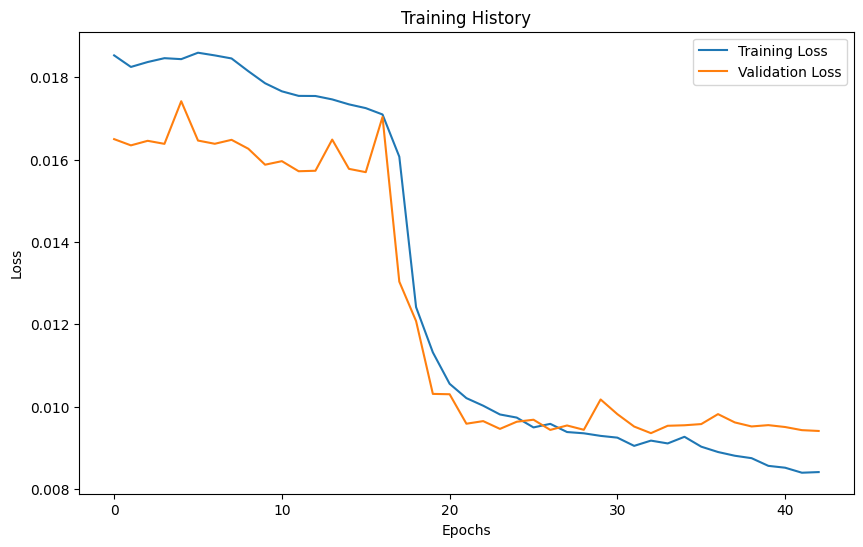

Development Set - MAE Valence: 0.0666, RMSE Valence: 0.0898, MAE Arousal: 0.0735, RMSE Arousal: 0.1037
Test Set - MAE Valence: 0.1151, RMSE Valence: 0.1533, MAE Arousal: 0.1064, RMSE Arousal: 0.1346


In [24]:
#fusion 1: 3x C-A _2 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=2, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Adjust video dimensions through 1D CNN
        self.conv1d_layer = nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, stride=2)
        # Encoder layers for audio and video
        self.video_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.audio_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # First cross-attention layer
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Second block of cross-attention applied three times
        self.cross_attention2 = nn.ModuleList([MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout) for _ in range(3)])
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        #print("audio", audio.shape)
        #print("video", video.shape)
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        #print("audio norm", audio_norm.shape)
        
        # Adjust video dimensions through 1D CNN
        video = video.permute(0, 2, 1)
        #print("video permuted", video.shape)
        video_cnn = self.conv1d_layer(video)
        #print("video cnn", video_cnn.shape)
        video_cnn = video_cnn.permute(0, 2, 1)
        #print("video cnn permuted", video_cnn.shape)

        # Process audio and video through their encoder layers
        video_encoded = self.video_encoder(video_cnn)
        audio_encoded = self.audio_encoder(audio_norm)

        # First block of cross-attention
        attn_output, _ = self.cross_attention1(video_encoded, audio_encoded, audio_encoded)

        # Second block of cross-attention applied three times consecutively
        for i in range(3):
            attn_output, _ = self.cross_attention2[i](attn_output, attn_output, attn_output)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output.permute(0, 2, 1)).squeeze()
        #print("pooled output", pooled_output.shape)
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion1-var1.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
    return train_losses, val_losses
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0194
Epoch 1, Validation Loss: 0.0164
Model saved to best_model_fusion1-var1.pth
Epoch 2, Training Loss: 0.0184
Epoch 2, Validation Loss: 0.0162
Model saved to best_model_fusion1-var1.pth
Epoch 3, Training Loss: 0.0183
Epoch 3, Validation Loss: 0.0166
Epoch 4, Training Loss: 0.0184
Epoch 4, Validation Loss: 0.0164
Epoch 5, Training Loss: 0.0183
Epoch 5, Validation Loss: 0.0167
Epoch 6, Training Loss: 0.0183
Epoch 6, Validation Loss: 0.0164
Epoch 7, Training Loss: 0.0185
Epoch 7, Validation Loss: 0.0164
Epoch 8, Training Loss: 0.0185
Epoch 8, Validation Loss: 0.0164
Epoch 9, Training Loss: 0.0185
Epoch 9, Validation Loss: 0.0164
Epoch 10, Training Loss: 0.0185
Epoch 10, Validation Loss: 0.0163
Epoch 11, Training Loss: 0.0182
Epoch 11, Validation Loss: 0.0162
Epoch 12, Training Loss: 0.0181
Epoch 12, Validation Loss: 0.0161
Model saved to best_model_fusion1-var1.pth
Epoch 13, Training Loss: 0.0180
Epoch 13, Validation Loss: 0.0159
Model saved to best_model_fusio

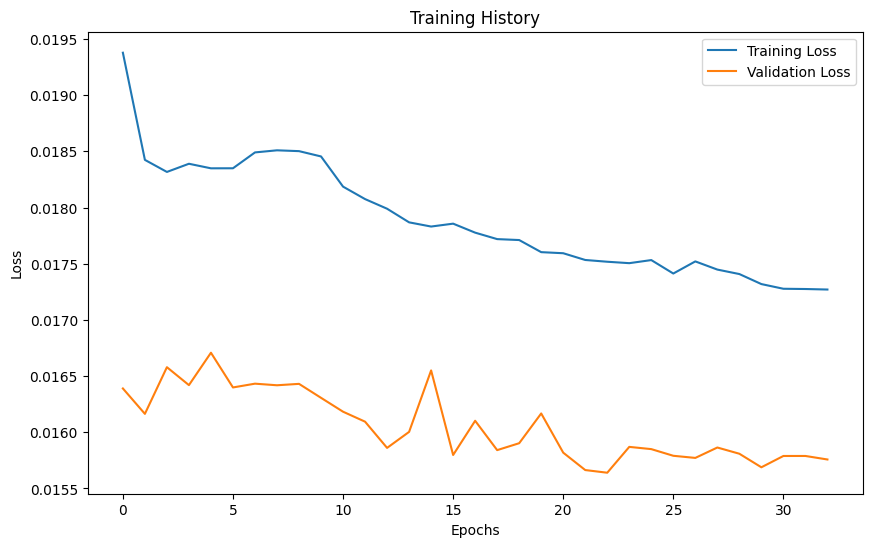

Development Set - MAE Valence: 0.0900, RMSE Valence: 0.1163, MAE Arousal: 0.1026, RMSE Arousal: 0.1341
Test Set - MAE Valence: 0.1370, RMSE Valence: 0.1835, MAE Arousal: 0.1338, RMSE Arousal: 0.1685


In [29]:
#fusion 1: 3x C-A _1 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=1, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Adjust video dimensions through 1D CNN
        self.conv1d_layer = nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, stride=1)
        # Encoder layers for audio and video
        self.video_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.audio_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # First cross-attention layer
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Second block of cross-attention applied three times
        self.cross_attention2 = nn.ModuleList([MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout) for _ in range(3)])
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        #print("audio", audio.shape)
        #print("video", video.shape)
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        #print("audio norm", audio_norm.shape)
        
        # Adjust video dimensions through 1D CNN
        video = video.permute(0, 2, 1)
        #print("video permuted", video.shape)
        video_cnn = self.conv1d_layer(video)
        #print("video cnn", video_cnn.shape)
        video_cnn = video_cnn.permute(0, 2, 1)
        #print("video cnn permuted", video_cnn.shape)

        # Process audio and video through their encoder layers
        video_encoded = self.video_encoder(video_cnn)
        audio_encoded = self.audio_encoder(audio_norm)

        # First block of cross-attention
        attn_output, _ = self.cross_attention1(video_encoded, audio_encoded, audio_encoded)

        # Second block of cross-attention applied three times consecutively
        for i in range(3):
            attn_output, _ = self.cross_attention2[i](attn_output, attn_output, attn_output)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output.permute(0, 2, 1)).squeeze()
        #print("pooled output", pooled_output.shape)
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion1-var1.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
    return train_losses, val_losses
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")

Epoch 1, Training Loss: 0.0169
Epoch 1, Validation Loss: 0.0108
Model saved to best_model_fusion1-var1_3sec.pth
Epoch 2, Training Loss: 0.0121
Epoch 2, Validation Loss: 0.0106
Model saved to best_model_fusion1-var1_3sec.pth
Epoch 3, Training Loss: 0.0110
Epoch 3, Validation Loss: 0.0107
Epoch 4, Training Loss: 0.0107
Epoch 4, Validation Loss: 0.0114
Epoch 5, Training Loss: 0.0115
Epoch 5, Validation Loss: 0.0096
Model saved to best_model_fusion1-var1_3sec.pth
Epoch 6, Training Loss: 0.0131
Epoch 6, Validation Loss: 0.0164
Epoch 7, Training Loss: 0.0183
Epoch 7, Validation Loss: 0.0164
Epoch 8, Training Loss: 0.0135
Epoch 8, Validation Loss: 0.0119
Epoch 9, Training Loss: 0.0115
Epoch 9, Validation Loss: 0.0099
Epoch 10, Training Loss: 0.0108
Epoch 10, Validation Loss: 0.0137
Epoch 11, Training Loss: 0.0111
Epoch 11, Validation Loss: 0.0107
Epoch 12, Training Loss: 0.0097
Epoch 12, Validation Loss: 0.0093
Model saved to best_model_fusion1-var1_3sec.pth
Epoch 13, Training Loss: 0.0094
Ep

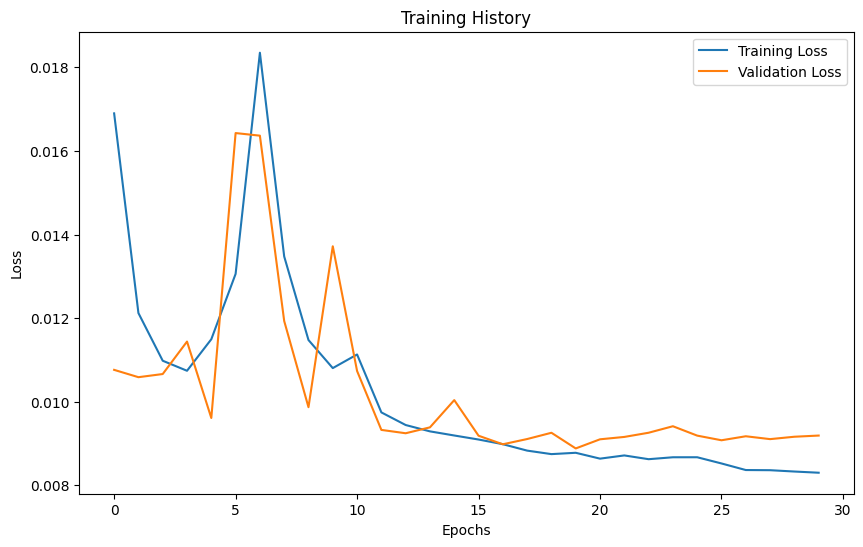

Development Set - MAE Valence: 0.0661, RMSE Valence: 0.0881, MAE Arousal: 0.0740, RMSE Arousal: 0.1028
Test Set - MAE Valence: 0.1165, RMSE Valence: 0.1548, MAE Arousal: 0.1097, RMSE Arousal: 0.1391


In [36]:
#fusion 1: 3x C-A _3 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=3, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Adjust video dimensions through 1D CNN
        self.conv1d_layer = nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, stride=3)
        # Encoder layers for audio and video
        self.video_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.audio_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # First cross-attention layer
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Second block of cross-attention applied three times
        self.cross_attention2 = nn.ModuleList([MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout) for _ in range(3)])
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        #print("audio", audio.shape)
        #print("video", video.shape)
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        #print("audio norm", audio_norm.shape)
        
        # Adjust video dimensions through 1D CNN
        video = video.permute(0, 2, 1)
        #print("video permuted", video.shape)
        video_cnn = self.conv1d_layer(video)
        #print("video cnn", video_cnn.shape)
        video_cnn = video_cnn.permute(0, 2, 1)
        #print("video cnn permuted", video_cnn.shape)

        # Process audio and video through their encoder layers
        video_encoded = self.video_encoder(video_cnn)
        audio_encoded = self.audio_encoder(audio_norm)

        # First block of cross-attention
        attn_output, _ = self.cross_attention1(video_encoded, audio_encoded, audio_encoded)

        # Second block of cross-attention applied three times consecutively
        for i in range(3):
            attn_output, _ = self.cross_attention2[i](attn_output, attn_output, attn_output)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output.permute(0, 2, 1)).squeeze()
        #print("pooled output", pooled_output.shape)
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion1-var1_3sec.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
    return train_losses, val_losses
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0152
Epoch 1, Validation Loss: 0.0089
Model saved to best_model_fusion1-var1_4sec.pth
Epoch 2, Training Loss: 0.0110
Epoch 2, Validation Loss: 0.0097
Epoch 3, Training Loss: 0.0108
Epoch 3, Validation Loss: 0.0101
Epoch 4, Training Loss: 0.0099
Epoch 4, Validation Loss: 0.0088
Model saved to best_model_fusion1-var1_4sec.pth
Epoch 5, Training Loss: 0.0103
Epoch 5, Validation Loss: 0.0127
Epoch 6, Training Loss: 0.0096
Epoch 6, Validation Loss: 0.0088
Epoch 7, Training Loss: 0.0094
Epoch 7, Validation Loss: 0.0097
Epoch 8, Training Loss: 0.0095
Epoch 8, Validation Loss: 0.0113
Epoch 9, Training Loss: 0.0093
Epoch 9, Validation Loss: 0.0089
Epoch 10, Training Loss: 0.0095
Epoch 10, Validation Loss: 0.0095
Epoch 11, Training Loss: 0.0082
Epoch 11, Validation Loss: 0.0088
Epoch 12, Training Loss: 0.0079
Epoch 12, Validation Loss: 0.0089
Epoch 13, Training Loss: 0.0079
Epoch 13, Validation Loss: 0.0090
Epoch 14, Training Loss: 0.0076
Epoch 14, Validation Loss: 0.008

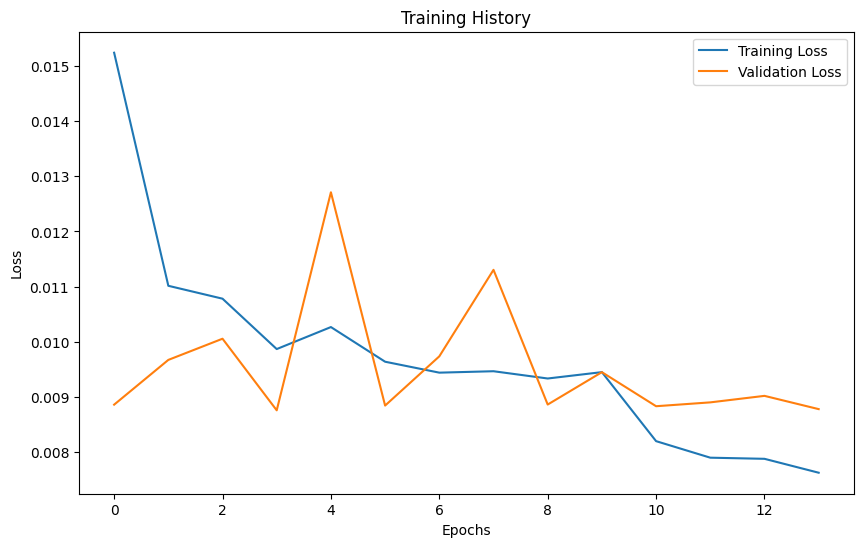

Development Set - MAE Valence: 0.0663, RMSE Valence: 0.0877, MAE Arousal: 0.0717, RMSE Arousal: 0.0992
Test Set - MAE Valence: 0.1196, RMSE Valence: 0.1589, MAE Arousal: 0.1042, RMSE Arousal: 0.1346


In [37]:
#fusion 1: 3x C-A _4 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=4, step=2):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Adjust video dimensions through 1D CNN
        self.conv1d_layer = nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, stride=3)
        # Encoder layers for audio and video
        self.video_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.audio_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # First cross-attention layer
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Second block of cross-attention applied three times
        self.cross_attention2 = nn.ModuleList([MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout) for _ in range(3)])
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        #print("audio", audio.shape)
        #print("video", video.shape)
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        #print("audio norm", audio_norm.shape)
        
        # Adjust video dimensions through 1D CNN
        video = video.permute(0, 2, 1)
        #print("video permuted", video.shape)
        video_cnn = self.conv1d_layer(video)
        #print("video cnn", video_cnn.shape)
        video_cnn = video_cnn.permute(0, 2, 1)
        #print("video cnn permuted", video_cnn.shape)

        # Process audio and video through their encoder layers
        video_encoded = self.video_encoder(video_cnn)
        audio_encoded = self.audio_encoder(audio_norm)

        # First block of cross-attention
        attn_output, _ = self.cross_attention1(video_encoded, audio_encoded, audio_encoded)

        # Second block of cross-attention applied three times consecutively
        for i in range(3):
            attn_output, _ = self.cross_attention2[i](attn_output, attn_output, attn_output)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output.permute(0, 2, 1)).squeeze()
        #print("pooled output", pooled_output.shape)
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion1-var1_4sec.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
    return train_losses, val_losses
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")

Epoch 1, Training Loss: 0.0299
Epoch 1, Validation Loss: 0.0101
Model saved to best_model_fusion1-var2.pth
Epoch 2, Training Loss: 0.0096
Epoch 2, Validation Loss: 0.0080
Model saved to best_model_fusion1-var2.pth
Epoch 3, Training Loss: 0.0089
Epoch 3, Validation Loss: 0.0106
Epoch 4, Training Loss: 0.0088
Epoch 4, Validation Loss: 0.0090
Epoch 5, Training Loss: 0.0087
Epoch 5, Validation Loss: 0.0087
Epoch 6, Training Loss: 0.0086
Epoch 6, Validation Loss: 0.0092
Epoch 7, Training Loss: 0.0086
Epoch 7, Validation Loss: 0.0095
Epoch 8, Training Loss: 0.0083
Epoch 8, Validation Loss: 0.0091
Epoch 9, Training Loss: 0.0076
Epoch 9, Validation Loss: 0.0083
Epoch 10, Training Loss: 0.0076
Epoch 10, Validation Loss: 0.0081
Epoch 11, Training Loss: 0.0076
Epoch 11, Validation Loss: 0.0083
Epoch 12, Training Loss: 0.0075
Epoch 12, Validation Loss: 0.0083
Early stopping triggered


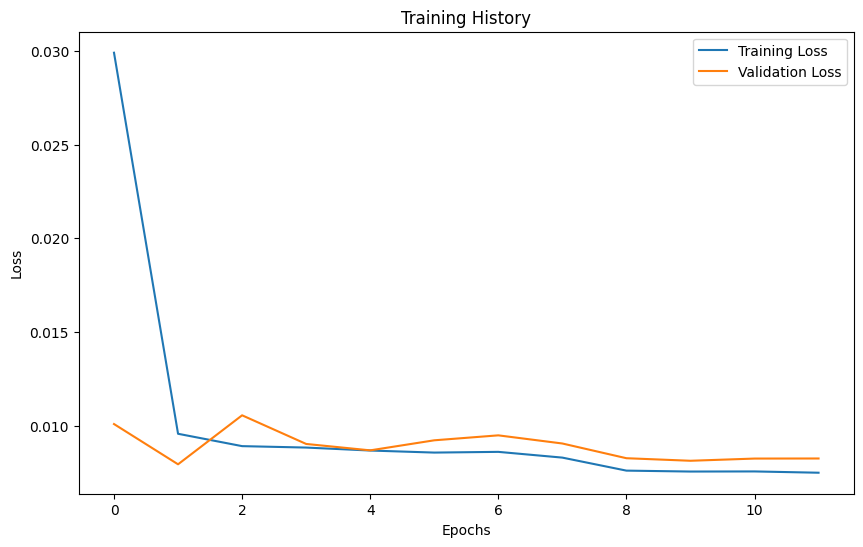

Development Set - MAE Valence: 0.0600, RMSE Valence: 0.0826, MAE Arousal: 0.0683, RMSE Arousal: 0.0984
Test Set - MAE Valence: 0.0867, RMSE Valence: 0.1098, MAE Arousal: 0.0937, RMSE Arousal: 0.1210


In [8]:
#fusion 1: query and VIDEO into C-A_ 2 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=2, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Adjust video dimensions through 1D CNN
        self.conv1d_layer = nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, stride=2)
        # Encoder layers for audio and video
        self.video_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.audio_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # First cross-attention layer
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Second block of cross-attention applied three times
        self.cross_attention2 = nn.ModuleList([MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout) for _ in range(3)])
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        #print("audio", audio.shape)
        #print("video", video.shape)
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        #print("audio norm", audio_norm.shape)
        
        # Adjust video dimensions through 1D CNN
        video = video.permute(0, 2, 1)
        #print("video permuted", video.shape)
        video_cnn = self.conv1d_layer(video)
        #print("video cnn", video_cnn.shape)
        video_cnn = video_cnn.permute(0, 2, 1)
        #print("video cnn permuted", video_cnn.shape)

        # Process audio and video through their encoder layers
        video_encoded = self.video_encoder(video_cnn)
        audio_encoded = self.audio_encoder(audio_norm)

        # First block of cross-attention
        attn_output, _ = self.cross_attention1(video_encoded, audio_encoded, audio_encoded)

        # Second block of cross-attention applied three times consecutively
        for i in range(3):
            if i == 0:
                query = attn_output
            else:
                query = attn_output
            attn_output, _ = self.cross_attention2[i](query, video_encoded, video_encoded)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output.permute(0, 2, 1)).squeeze()
        #print("pooled output", pooled_output.shape)
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion1-var2.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses

def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0279
Epoch 1, Validation Loss: 0.0083
Model saved to best_model_fusion1-var2-1sec.pth
Epoch 2, Training Loss: 0.0091
Epoch 2, Validation Loss: 0.0093
Epoch 3, Training Loss: 0.0087
Epoch 3, Validation Loss: 0.0080
Model saved to best_model_fusion1-var2-1sec.pth
Epoch 4, Training Loss: 0.0086
Epoch 4, Validation Loss: 0.0089
Epoch 5, Training Loss: 0.0086
Epoch 5, Validation Loss: 0.0084
Epoch 6, Training Loss: 0.0083
Epoch 6, Validation Loss: 0.0079
Model saved to best_model_fusion1-var2-1sec.pth
Epoch 7, Training Loss: 0.0083
Epoch 7, Validation Loss: 0.0079
Epoch 8, Training Loss: 0.0080
Epoch 8, Validation Loss: 0.0082
Epoch 9, Training Loss: 0.0081
Epoch 9, Validation Loss: 0.0082
Epoch 10, Training Loss: 0.0079
Epoch 10, Validation Loss: 0.0087
Epoch 11, Training Loss: 0.0080
Epoch 11, Validation Loss: 0.0079
Epoch 12, Training Loss: 0.0080
Epoch 12, Validation Loss: 0.0089
Epoch 13, Training Loss: 0.0072
Epoch 13, Validation Loss: 0.0080
Epoch 14, Traini

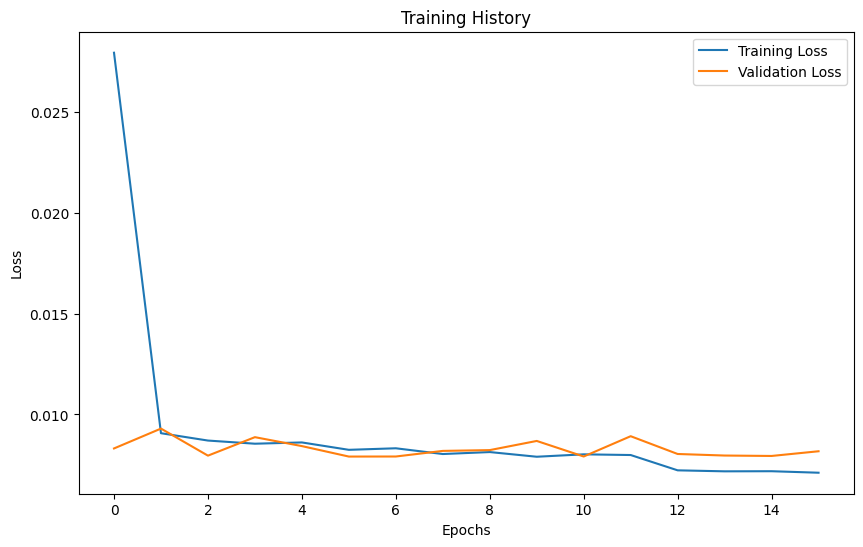

Development Set - MAE Valence: 0.0588, RMSE Valence: 0.0813, MAE Arousal: 0.0696, RMSE Arousal: 0.0987
Test Set - MAE Valence: 0.0861, RMSE Valence: 0.1106, MAE Arousal: 0.0932, RMSE Arousal: 0.1208


In [11]:
#fusion 1: query and VIDEO into C-A_ 1 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=1, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Adjust video dimensions through 1D CNN
        self.conv1d_layer = nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, stride=1)
        # Encoder layers for audio and video
        self.video_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.audio_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # First cross-attention layer
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Second block of cross-attention applied three times
        self.cross_attention2 = nn.ModuleList([MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout) for _ in range(3)])
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        #print("audio", audio.shape)
        #print("video", video.shape)
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        #print("audio norm", audio_norm.shape)
        
        # Adjust video dimensions through 1D CNN
        video = video.permute(0, 2, 1)
        #print("video permuted", video.shape)
        video_cnn = self.conv1d_layer(video)
        #print("video cnn", video_cnn.shape)
        video_cnn = video_cnn.permute(0, 2, 1)
        #print("video cnn permuted", video_cnn.shape)

        # Process audio and video through their encoder layers
        video_encoded = self.video_encoder(video_cnn)
        audio_encoded = self.audio_encoder(audio_norm)

        # First block of cross-attention
        attn_output, _ = self.cross_attention1(video_encoded, audio_encoded, audio_encoded)

        # Second block of cross-attention applied three times consecutively
        for i in range(3):
            if i == 0:
                query = attn_output
            else:
                query = attn_output
            attn_output, _ = self.cross_attention2[i](query, video_encoded, video_encoded)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output.permute(0, 2, 1)).squeeze()
        #print("pooled output", pooled_output.shape)
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion1-var2-1sec.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0273
Epoch 1, Validation Loss: 0.0085
Model saved to best_model_fusion1-var2-3sec.pth
Epoch 2, Training Loss: 0.0088
Epoch 2, Validation Loss: 0.0075
Model saved to best_model_fusion1-var2-3sec.pth
Epoch 3, Training Loss: 0.0082
Epoch 3, Validation Loss: 0.0078
Epoch 4, Training Loss: 0.0080
Epoch 4, Validation Loss: 0.0077
Epoch 5, Training Loss: 0.0077
Epoch 5, Validation Loss: 0.0093
Epoch 6, Training Loss: 0.0079
Epoch 6, Validation Loss: 0.0079
Epoch 7, Training Loss: 0.0076
Epoch 7, Validation Loss: 0.0084
Epoch 8, Training Loss: 0.0078
Epoch 8, Validation Loss: 0.0092
Epoch 9, Training Loss: 0.0069
Epoch 9, Validation Loss: 0.0078
Epoch 10, Training Loss: 0.0067
Epoch 10, Validation Loss: 0.0077
Epoch 11, Training Loss: 0.0067
Epoch 11, Validation Loss: 0.0080
Epoch 12, Training Loss: 0.0066
Epoch 12, Validation Loss: 0.0079
Early stopping triggered


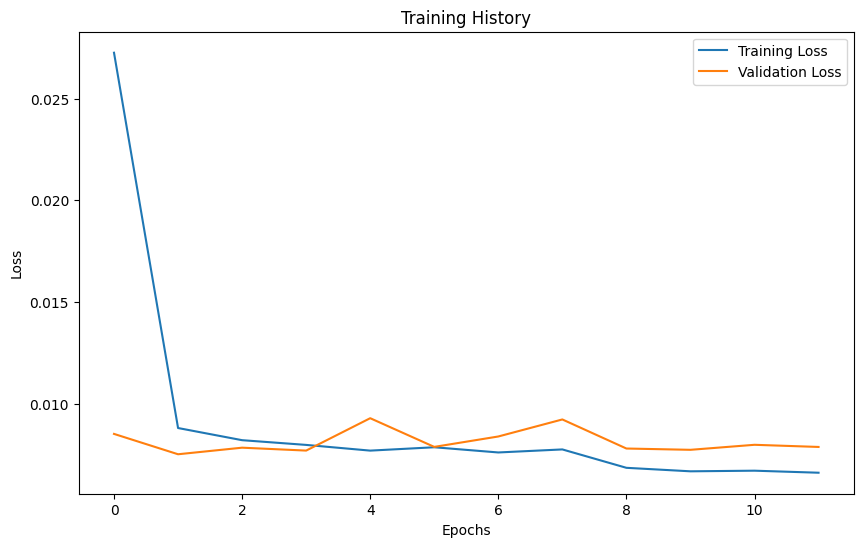

Development Set - MAE Valence: 0.0594, RMSE Valence: 0.0822, MAE Arousal: 0.0672, RMSE Arousal: 0.0944
Test Set - MAE Valence: 0.0827, RMSE Valence: 0.1050, MAE Arousal: 0.0976, RMSE Arousal: 0.1261


In [12]:
#fusion 1: query and VIDEO into C-A_ 3 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=3, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Adjust video dimensions through 1D CNN
        self.conv1d_layer = nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, stride=3)
        # Encoder layers for audio and video
        self.video_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.audio_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # First cross-attention layer
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Second block of cross-attention applied three times
        self.cross_attention2 = nn.ModuleList([MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout) for _ in range(3)])
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        #print("audio", audio.shape)
        #print("video", video.shape)
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        #print("audio norm", audio_norm.shape)
        
        # Adjust video dimensions through 1D CNN
        video = video.permute(0, 2, 1)
        #print("video permuted", video.shape)
        video_cnn = self.conv1d_layer(video)
        #print("video cnn", video_cnn.shape)
        video_cnn = video_cnn.permute(0, 2, 1)
        #print("video cnn permuted", video_cnn.shape)

        # Process audio and video through their encoder layers
        video_encoded = self.video_encoder(video_cnn)
        audio_encoded = self.audio_encoder(audio_norm)

        # First block of cross-attention
        attn_output, _ = self.cross_attention1(video_encoded, audio_encoded, audio_encoded)

        # Second block of cross-attention applied three times consecutively
        for i in range(3):
            if i == 0:
                query = attn_output
            else:
                query = attn_output
            attn_output, _ = self.cross_attention2[i](query, video_encoded, video_encoded)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output.permute(0, 2, 1)).squeeze()
        #print("pooled output", pooled_output.shape)
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion1-var2-3sec.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0451
Epoch 1, Validation Loss: 0.0098
Model saved to best_model_fusion1-var2-4sec.pth
Epoch 2, Training Loss: 0.0091
Epoch 2, Validation Loss: 0.0076
Model saved to best_model_fusion1-var2-4sec.pth
Epoch 3, Training Loss: 0.0087
Epoch 3, Validation Loss: 0.0093
Epoch 4, Training Loss: 0.0083
Epoch 4, Validation Loss: 0.0090
Epoch 5, Training Loss: 0.0084
Epoch 5, Validation Loss: 0.0077
Epoch 6, Training Loss: 0.0081
Epoch 6, Validation Loss: 0.0088
Epoch 7, Training Loss: 0.0085
Epoch 7, Validation Loss: 0.0079
Epoch 8, Training Loss: 0.0077
Epoch 8, Validation Loss: 0.0077
Epoch 9, Training Loss: 0.0069
Epoch 9, Validation Loss: 0.0077
Epoch 10, Training Loss: 0.0068
Epoch 10, Validation Loss: 0.0077
Epoch 11, Training Loss: 0.0068
Epoch 11, Validation Loss: 0.0077
Epoch 12, Training Loss: 0.0068
Epoch 12, Validation Loss: 0.0077
Early stopping triggered


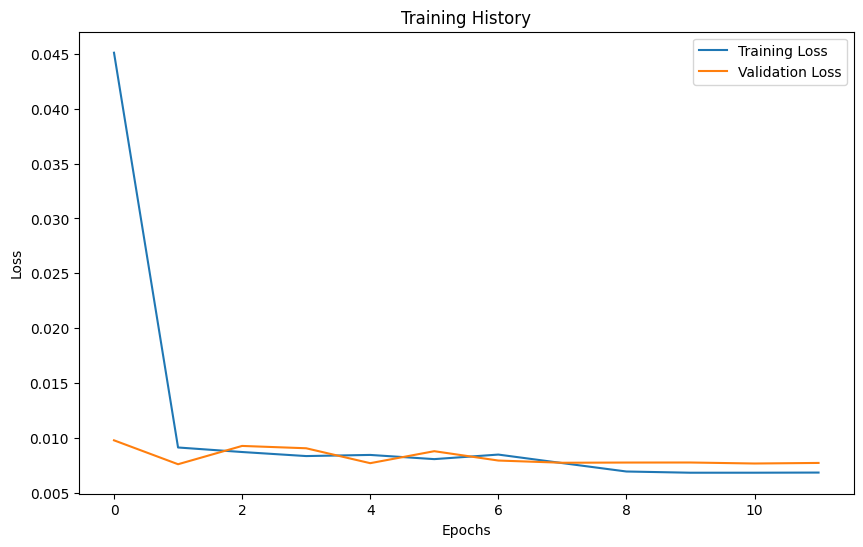

Development Set - MAE Valence: 0.0583, RMSE Valence: 0.0809, MAE Arousal: 0.0679, RMSE Arousal: 0.0940
Test Set - MAE Valence: 0.0816, RMSE Valence: 0.1033, MAE Arousal: 0.0971, RMSE Arousal: 0.1250


In [42]:
#fusion 1: query and VIDEO into C-A_ 4 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=4, step=2):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Adjust video dimensions through 1D CNN
        self.conv1d_layer = nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, stride=3)
        # Encoder layers for audio and video
        self.video_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.audio_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # First cross-attention layer
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Second block of cross-attention applied three times
        self.cross_attention2 = nn.ModuleList([MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout) for _ in range(3)])
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        #print("audio", audio.shape)
        #print("video", video.shape)
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        #print("audio norm", audio_norm.shape)
        
        # Adjust video dimensions through 1D CNN
        video = video.permute(0, 2, 1)
        #print("video permuted", video.shape)
        video_cnn = self.conv1d_layer(video)
        #print("video cnn", video_cnn.shape)
        video_cnn = video_cnn.permute(0, 2, 1)
        #print("video cnn permuted", video_cnn.shape)

        # Process audio and video through their encoder layers
        video_encoded = self.video_encoder(video_cnn)
        audio_encoded = self.audio_encoder(audio_norm)

        # First block of cross-attention
        attn_output, _ = self.cross_attention1(video_encoded, audio_encoded, audio_encoded)

        # Second block of cross-attention applied three times consecutively
        for i in range(3):
            if i == 0:
                query = attn_output
            else:
                query = attn_output
            attn_output, _ = self.cross_attention2[i](query, video_encoded, video_encoded)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output.permute(0, 2, 1)).squeeze()
        #print("pooled output", pooled_output.shape)
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion1-var2-4sec.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0343
Epoch 1, Validation Loss: 0.0189
Model saved to best_model_fusion1-var3.pth
Epoch 2, Training Loss: 0.0189
Epoch 2, Validation Loss: 0.0163
Model saved to best_model_fusion1-var3.pth
Epoch 3, Training Loss: 0.0187
Epoch 3, Validation Loss: 0.0183
Epoch 4, Training Loss: 0.0186
Epoch 4, Validation Loss: 0.0165
Epoch 5, Training Loss: 0.0185
Epoch 5, Validation Loss: 0.0170
Epoch 6, Training Loss: 0.0184
Epoch 6, Validation Loss: 0.0166
Epoch 7, Training Loss: 0.0181
Epoch 7, Validation Loss: 0.0171
Epoch 8, Training Loss: 0.0182
Epoch 8, Validation Loss: 0.0178
Epoch 9, Training Loss: 0.0173
Epoch 9, Validation Loss: 0.0155
Model saved to best_model_fusion1-var3.pth
Epoch 10, Training Loss: 0.0172
Epoch 10, Validation Loss: 0.0154
Model saved to best_model_fusion1-var3.pth
Epoch 11, Training Loss: 0.0171
Epoch 11, Validation Loss: 0.0157
Epoch 12, Training Loss: 0.0170
Epoch 12, Validation Loss: 0.0155
Epoch 13, Training Loss: 0.0169
Epoch 13, Validation L

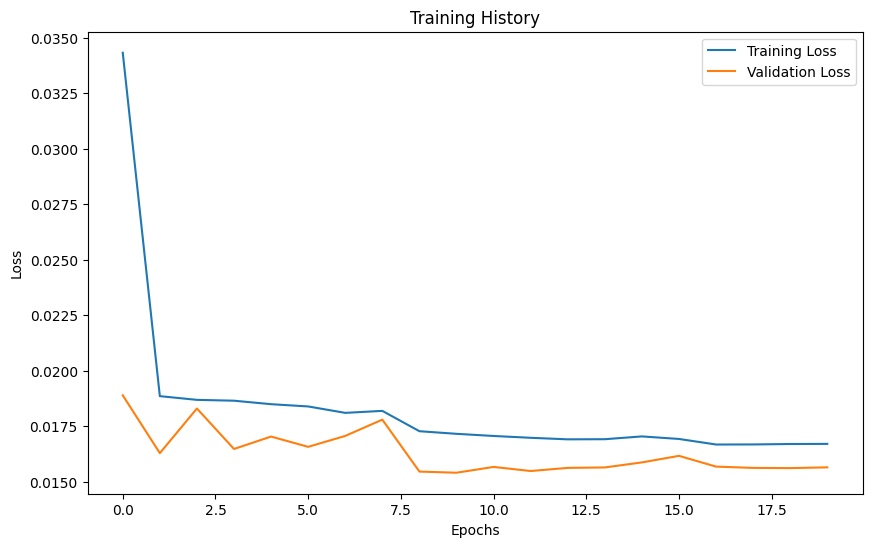

Development Set - MAE Valence: 0.0910, RMSE Valence: 0.1171, MAE Arousal: 0.1001, RMSE Arousal: 0.1326
Test Set - MAE Valence: 0.1385, RMSE Valence: 0.1855, MAE Arousal: 0.1341, RMSE Arousal: 0.1678


In [2]:
#fusion 1: query and AUDIO into C-A
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=2, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Adjust video dimensions through 1D CNN
        self.conv1d_layer = nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, stride=2)
        # Encoder layers for audio and video
        self.video_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.audio_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # First cross-attention layer
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Second block of cross-attention applied three times
        self.cross_attention2 = nn.ModuleList([MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout) for _ in range(3)])
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        #print("audio", audio.shape)
        #print("video", video.shape)
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        #print("audio norm", audio_norm.shape)
        
        # Adjust video dimensions through 1D CNN
        video = video.permute(0, 2, 1)
        #print("video permuted", video.shape)
        video_cnn = self.conv1d_layer(video)
        #print("video cnn", video_cnn.shape)
        video_cnn = video_cnn.permute(0, 2, 1)
        #print("video cnn permuted", video_cnn.shape)

        # Process audio and video through their encoder layers
        video_encoded = self.video_encoder(video_cnn)
        audio_encoded = self.audio_encoder(audio_norm)

        # First block of cross-attention
        attn_output, _ = self.cross_attention1(video_encoded, audio_encoded, audio_encoded)

        # Second block of cross-attention applied three times consecutively
        for i in range(3):
            if i == 0:
                query = attn_output
            else:
                query = attn_output
            attn_output, _ = self.cross_attention2[i](query, audio_encoded, audio_encoded)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output.permute(0, 2, 1)).squeeze()
        #print("pooled output", pooled_output.shape)
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion1-var3.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")

Epoch 1, Training Loss: 0.0382
Epoch 1, Validation Loss: 0.0211
Model saved to best_model_fusion1-var3_1sec.pth
Epoch 2, Training Loss: 0.0189
Epoch 2, Validation Loss: 0.0165
Model saved to best_model_fusion1-var3_1sec.pth
Epoch 3, Training Loss: 0.0189
Epoch 3, Validation Loss: 0.0169
Epoch 4, Training Loss: 0.0189
Epoch 4, Validation Loss: 0.0174
Epoch 5, Training Loss: 0.0188
Epoch 5, Validation Loss: 0.0165
Epoch 6, Training Loss: 0.0187
Epoch 6, Validation Loss: 0.0165
Epoch 7, Training Loss: 0.0186
Epoch 7, Validation Loss: 0.0170
Epoch 8, Training Loss: 0.0186
Epoch 8, Validation Loss: 0.0170
Epoch 9, Training Loss: 0.0179
Epoch 9, Validation Loss: 0.0160
Model saved to best_model_fusion1-var3_1sec.pth
Epoch 10, Training Loss: 0.0178
Epoch 10, Validation Loss: 0.0159
Model saved to best_model_fusion1-var3_1sec.pth
Epoch 11, Training Loss: 0.0177
Epoch 11, Validation Loss: 0.0157
Model saved to best_model_fusion1-var3_1sec.pth
Epoch 12, Training Loss: 0.0177
Epoch 12, Validation

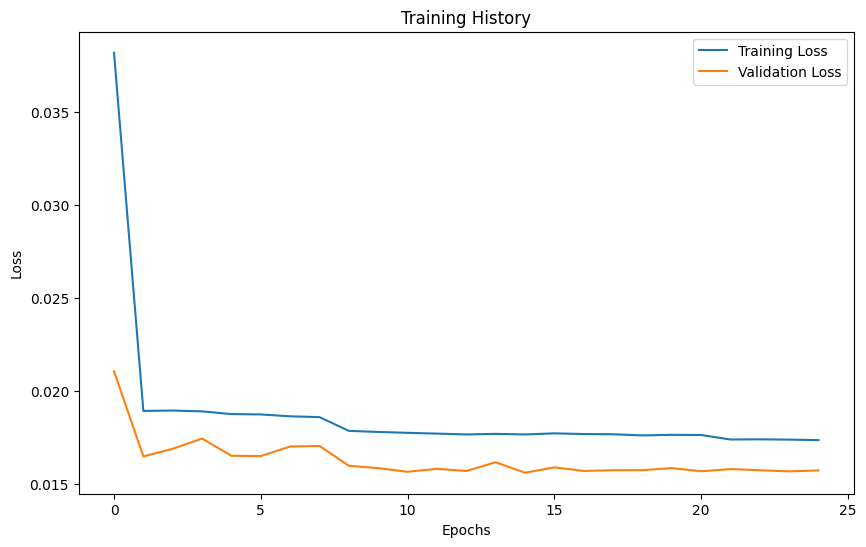

Development Set - MAE Valence: 0.0906, RMSE Valence: 0.1166, MAE Arousal: 0.1023, RMSE Arousal: 0.1337
Test Set - MAE Valence: 0.1379, RMSE Valence: 0.1852, MAE Arousal: 0.1337, RMSE Arousal: 0.1683


In [3]:
#fusion 1: query and AUDIO into C-A_ 1 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=1, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Adjust video dimensions through 1D CNN
        self.conv1d_layer = nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, stride=1)
        # Encoder layers for audio and video
        self.video_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.audio_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # First cross-attention layer
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Second block of cross-attention applied three times
        self.cross_attention2 = nn.ModuleList([MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout) for _ in range(3)])
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        #print("audio", audio.shape)
        #print("video", video.shape)
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        #print("audio norm", audio_norm.shape)
        
        # Adjust video dimensions through 1D CNN
        video = video.permute(0, 2, 1)
        #print("video permuted", video.shape)
        video_cnn = self.conv1d_layer(video)
        #print("video cnn", video_cnn.shape)
        video_cnn = video_cnn.permute(0, 2, 1)
        #print("video cnn permuted", video_cnn.shape)

        # Process audio and video through their encoder layers
        video_encoded = self.video_encoder(video_cnn)
        audio_encoded = self.audio_encoder(audio_norm)

        # First block of cross-attention
        attn_output, _ = self.cross_attention1(video_encoded, audio_encoded, audio_encoded)

        # Second block of cross-attention applied three times consecutively
        for i in range(3):
            if i == 0:
                query = attn_output
            else:
                query = attn_output
            attn_output, _ = self.cross_attention2[i](query, audio_encoded, audio_encoded)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output.permute(0, 2, 1)).squeeze()
        #print("pooled output", pooled_output.shape)
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion1-var3_1sec.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0353
Epoch 1, Validation Loss: 0.0165
Model saved to best_model_fusion1-var3_3sec.pth
Epoch 2, Training Loss: 0.0188
Epoch 2, Validation Loss: 0.0163
Model saved to best_model_fusion1-var3_3sec.pth
Epoch 3, Training Loss: 0.0187
Epoch 3, Validation Loss: 0.0164
Epoch 4, Training Loss: 0.0186
Epoch 4, Validation Loss: 0.0158
Model saved to best_model_fusion1-var3_3sec.pth
Epoch 5, Training Loss: 0.0181
Epoch 5, Validation Loss: 0.0177
Epoch 6, Training Loss: 0.0180
Epoch 6, Validation Loss: 0.0171
Epoch 7, Training Loss: 0.0178
Epoch 7, Validation Loss: 0.0159
Epoch 8, Training Loss: 0.0179
Epoch 8, Validation Loss: 0.0159
Epoch 9, Training Loss: 0.0178
Epoch 9, Validation Loss: 0.0159
Epoch 10, Training Loss: 0.0177
Epoch 10, Validation Loss: 0.0162
Epoch 11, Training Loss: 0.0166
Epoch 11, Validation Loss: 0.0161
Epoch 12, Training Loss: 0.0165
Epoch 12, Validation Loss: 0.0162
Epoch 13, Training Loss: 0.0164
Epoch 13, Validation Loss: 0.0158
Model saved to b

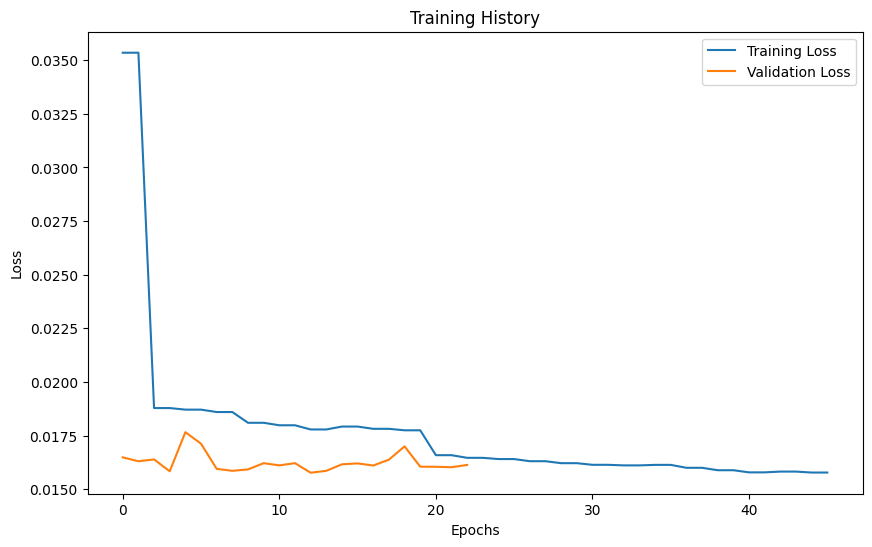

Development Set - MAE Valence: 0.0922, RMSE Valence: 0.1195, MAE Arousal: 0.1022, RMSE Arousal: 0.1341
Test Set - MAE Valence: 0.1379, RMSE Valence: 0.1842, MAE Arousal: 0.1374, RMSE Arousal: 0.1713


In [4]:
#fusion 1: query and AUDIO into C-A_ 3 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=3, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Adjust video dimensions through 1D CNN
        self.conv1d_layer = nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, stride=3)
        # Encoder layers for audio and video
        self.video_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.audio_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # First cross-attention layer
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Second block of cross-attention applied three times
        self.cross_attention2 = nn.ModuleList([MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout) for _ in range(3)])
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        #print("audio", audio.shape)
        #print("video", video.shape)
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        #print("audio norm", audio_norm.shape)
        
        # Adjust video dimensions through 1D CNN
        video = video.permute(0, 2, 1)
        #print("video permuted", video.shape)
        video_cnn = self.conv1d_layer(video)
        #print("video cnn", video_cnn.shape)
        video_cnn = video_cnn.permute(0, 2, 1)
        #print("video cnn permuted", video_cnn.shape)

        # Process audio and video through their encoder layers
        video_encoded = self.video_encoder(video_cnn)
        audio_encoded = self.audio_encoder(audio_norm)

        # First block of cross-attention
        attn_output, _ = self.cross_attention1(video_encoded, audio_encoded, audio_encoded)

        # Second block of cross-attention applied three times consecutively
        for i in range(3):
            if i == 0:
                query = attn_output
            else:
                query = attn_output
            attn_output, _ = self.cross_attention2[i](query, audio_encoded, audio_encoded)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output.permute(0, 2, 1)).squeeze()
        #print("pooled output", pooled_output.shape)
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion1-var3_3sec.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            train_losses.append(avg_loss)
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0543
Epoch 1, Validation Loss: 0.0164
Model saved to best_model_fusion1-var3_4sec.pth
Epoch 2, Training Loss: 0.0192
Epoch 2, Validation Loss: 0.0176
Epoch 3, Training Loss: 0.0184
Epoch 3, Validation Loss: 0.0161
Model saved to best_model_fusion1-var3_4sec.pth
Epoch 4, Training Loss: 0.0185
Epoch 4, Validation Loss: 0.0162
Epoch 5, Training Loss: 0.0184
Epoch 5, Validation Loss: 0.0161
Model saved to best_model_fusion1-var3_4sec.pth
Epoch 6, Training Loss: 0.0182
Epoch 6, Validation Loss: 0.0167
Epoch 7, Training Loss: 0.0181
Epoch 7, Validation Loss: 0.0173
Epoch 8, Training Loss: 0.0186
Epoch 8, Validation Loss: 0.0224
Epoch 9, Training Loss: 0.0187
Epoch 9, Validation Loss: 0.0173
Epoch 10, Training Loss: 0.0181
Epoch 10, Validation Loss: 0.0156
Model saved to best_model_fusion1-var3_4sec.pth
Epoch 11, Training Loss: 0.0179
Epoch 11, Validation Loss: 0.0184
Epoch 12, Training Loss: 0.0178
Epoch 12, Validation Loss: 0.0161
Epoch 13, Training Loss: 0.0176
Ep

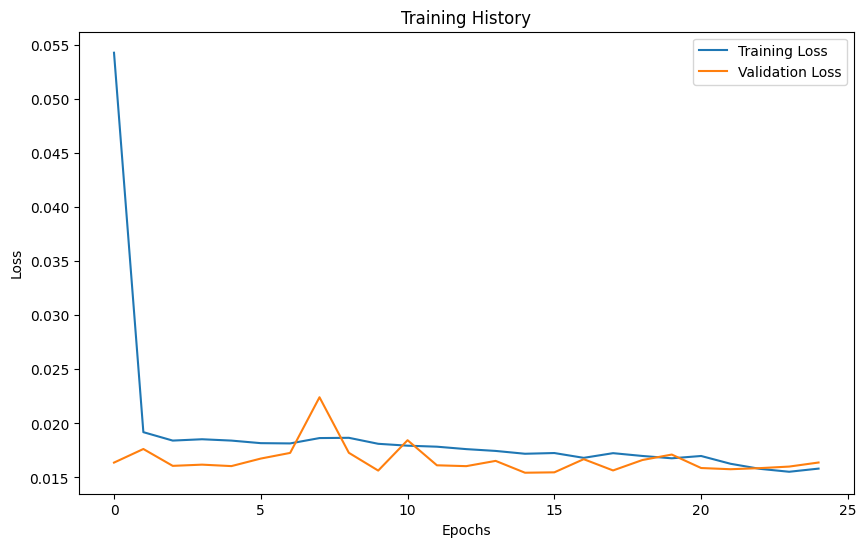

Development Set - MAE Valence: 0.0908, RMSE Valence: 0.1193, MAE Arousal: 0.1034, RMSE Arousal: 0.1363
Test Set - MAE Valence: 0.1377, RMSE Valence: 0.1836, MAE Arousal: 0.1368, RMSE Arousal: 0.1719


In [5]:
#fusion 1: query and AUDIO into C-A_ 4 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=4, step=2):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Adjust video dimensions through 1D CNN
        self.conv1d_layer = nn.Conv1d(in_channels=embed_size, out_channels=embed_size, kernel_size=3, stride=3)
        # Encoder layers for audio and video
        self.video_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        self.audio_encoder = EncoderLayer(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # First cross-attention layer
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Second block of cross-attention applied three times
        self.cross_attention2 = nn.ModuleList([MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout) for _ in range(3)])
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        #print("audio", audio.shape)
        #print("video", video.shape)
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        #print("audio norm", audio_norm.shape)
        
        # Adjust video dimensions through 1D CNN
        video = video.permute(0, 2, 1)
        #print("video permuted", video.shape)
        video_cnn = self.conv1d_layer(video)
        #print("video cnn", video_cnn.shape)
        video_cnn = video_cnn.permute(0, 2, 1)
        #print("video cnn permuted", video_cnn.shape)

        # Process audio and video through their encoder layers
        video_encoded = self.video_encoder(video_cnn)
        audio_encoded = self.audio_encoder(audio_norm)

        # First block of cross-attention
        attn_output, _ = self.cross_attention1(video_encoded, audio_encoded, audio_encoded)

        # Second block of cross-attention applied three times consecutively
        for i in range(3):
            if i == 0:
                query = attn_output
            else:
                query = attn_output
            attn_output, _ = self.cross_attention2[i](query, audio_encoded, audio_encoded)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output.permute(0, 2, 1)).squeeze()
        #print("pooled output", pooled_output.shape)
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion1-var3_4sec.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0118
Epoch 1, Validation Loss: 0.0094
Model saved to best_model_fusion2.pth
Epoch 2, Training Loss: 0.0094
Epoch 2, Validation Loss: 0.0114
Epoch 3, Training Loss: 0.0085
Epoch 3, Validation Loss: 0.0087
Model saved to best_model_fusion2.pth
Epoch 4, Training Loss: 0.0082
Epoch 4, Validation Loss: 0.0087
Model saved to best_model_fusion2.pth
Epoch 5, Training Loss: 0.0079
Epoch 5, Validation Loss: 0.0092
Epoch 6, Training Loss: 0.0078
Epoch 6, Validation Loss: 0.0101
Epoch 7, Training Loss: 0.0077
Epoch 7, Validation Loss: 0.0097
Epoch 8, Training Loss: 0.0075
Epoch 8, Validation Loss: 0.0094
Epoch 9, Training Loss: 0.0074
Epoch 9, Validation Loss: 0.0086
Model saved to best_model_fusion2.pth
Epoch 10, Training Loss: 0.0075
Epoch 10, Validation Loss: 0.0085
Model saved to best_model_fusion2.pth
Epoch 11, Training Loss: 0.0075
Epoch 11, Validation Loss: 0.0092
Epoch 12, Training Loss: 0.0074
Epoch 12, Validation Loss: 0.0087
Epoch 13, Training Loss: 0.0071
Epoc

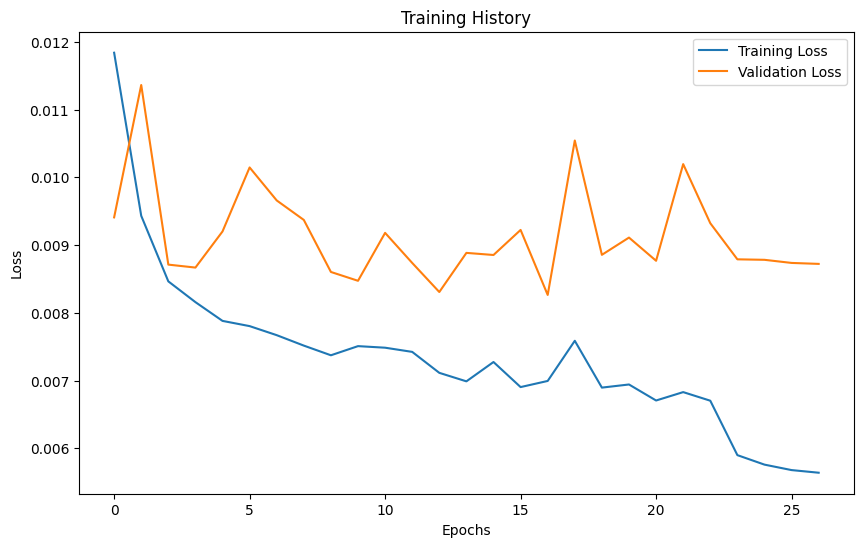

Development Set - MAE Valence: 0.0619, RMSE Valence: 0.0848, MAE Arousal: 0.0727, RMSE Arousal: 0.1012
Test Set - MAE Valence: 0.1058, RMSE Valence: 0.1401, MAE Arousal: 0.1034, RMSE Arousal: 0.1328


In [6]:
#fusion 2: 2 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=2, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Encoder layers for audio and video are not needed if we are using attention directly
        # First cross-attention layer for processing both video and audio together
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Self-attention as the second block
        self.self_attention = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        # Pad audio features to match video's sequence length
        seq_len_diff = video.size(1) - audio_norm.size(1)
        if seq_len_diff > 0:
            padding = torch.zeros((audio_norm.size(0), seq_len_diff, audio_norm.size(2)), device=audio_norm.device)
            audio_padded = torch.cat([audio_norm, padding], dim=1)
        else:
            audio_padded = audio_norm

        # First block of cross-attention
        attn_output1, _ = self.cross_attention1(video, audio_padded, audio_padded)

        # Second block of self-attention
        attn_output2, _ = self.self_attention(attn_output1, attn_output1, attn_output1)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output2.permute(0, 2, 1)).squeeze()
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion2.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")

Epoch 1, Training Loss: 0.0111
Epoch 1, Validation Loss: 0.0103
Model saved to best_model_fusion2.pth
Epoch 2, Training Loss: 0.0094
Epoch 2, Validation Loss: 0.0090
Model saved to best_model_fusion2.pth
Epoch 3, Training Loss: 0.0087
Epoch 3, Validation Loss: 0.0082
Model saved to best_model_fusion2.pth
Epoch 4, Training Loss: 0.0082
Epoch 4, Validation Loss: 0.0081
Model saved to best_model_fusion2.pth
Epoch 5, Training Loss: 0.0080
Epoch 5, Validation Loss: 0.0089
Epoch 6, Training Loss: 0.0078
Epoch 6, Validation Loss: 0.0085
Epoch 7, Training Loss: 0.0077
Epoch 7, Validation Loss: 0.0083
Epoch 8, Training Loss: 0.0077
Epoch 8, Validation Loss: 0.0085
Epoch 9, Training Loss: 0.0075
Epoch 9, Validation Loss: 0.0084
Epoch 10, Training Loss: 0.0075
Epoch 10, Validation Loss: 0.0089
Epoch 11, Training Loss: 0.0069
Epoch 11, Validation Loss: 0.0081
Model saved to best_model_fusion2.pth
Epoch 12, Training Loss: 0.0068
Epoch 12, Validation Loss: 0.0081
Epoch 13, Training Loss: 0.0067
Epoc

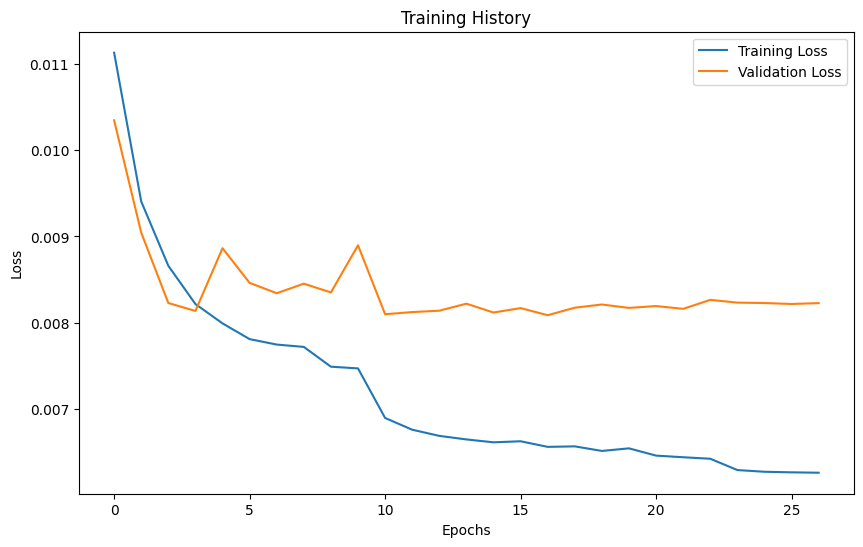

Development Set - MAE Valence: 0.0606, RMSE Valence: 0.0822, MAE Arousal: 0.0709, RMSE Arousal: 0.0985
Test Set - MAE Valence: 0.0928, RMSE Valence: 0.1206, MAE Arousal: 0.1025, RMSE Arousal: 0.1355


In [8]:
#fusion 2: 1 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=1, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Encoder layers for audio and video are not needed if we are using attention directly
        # First cross-attention layer for processing both video and audio together
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Self-attention as the second block
        self.self_attention = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        # Pad audio features to match video's sequence length
        seq_len_diff = video.size(1) - audio_norm.size(1)
        if seq_len_diff > 0:
            padding = torch.zeros((audio_norm.size(0), seq_len_diff, audio_norm.size(2)), device=audio_norm.device)
            audio_padded = torch.cat([audio_norm, padding], dim=1)
        else:
            audio_padded = audio_norm

        # First block of cross-attention
        attn_output1, _ = self.cross_attention1(video, audio_padded, audio_padded)

        # Second block of self-attention
        attn_output2, _ = self.self_attention(attn_output1, attn_output1, attn_output1)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output2.permute(0, 2, 1)).squeeze()
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion2.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")

Epoch 1, Training Loss: 0.0120
Epoch 1, Validation Loss: 0.0092
Model saved to best_model_fusion2-3sec.pth
Epoch 2, Training Loss: 0.0089
Epoch 2, Validation Loss: 0.0090
Model saved to best_model_fusion2-3sec.pth
Epoch 3, Training Loss: 0.0088
Epoch 3, Validation Loss: 0.0096
Epoch 4, Training Loss: 0.0082
Epoch 4, Validation Loss: 0.0085
Model saved to best_model_fusion2-3sec.pth
Epoch 5, Training Loss: 0.0079
Epoch 5, Validation Loss: 0.0098
Epoch 6, Training Loss: 0.0077
Epoch 6, Validation Loss: 0.0094
Epoch 7, Training Loss: 0.0077
Epoch 7, Validation Loss: 0.0090
Epoch 8, Training Loss: 0.0074
Epoch 8, Validation Loss: 0.0085
Epoch 9, Training Loss: 0.0072
Epoch 9, Validation Loss: 0.0090
Epoch 10, Training Loss: 0.0074
Epoch 10, Validation Loss: 0.0088
Epoch 11, Training Loss: 0.0065
Epoch 11, Validation Loss: 0.0085
Epoch 12, Training Loss: 0.0064
Epoch 12, Validation Loss: 0.0086
Epoch 13, Training Loss: 0.0063
Epoch 13, Validation Loss: 0.0086
Epoch 14, Training Loss: 0.0062

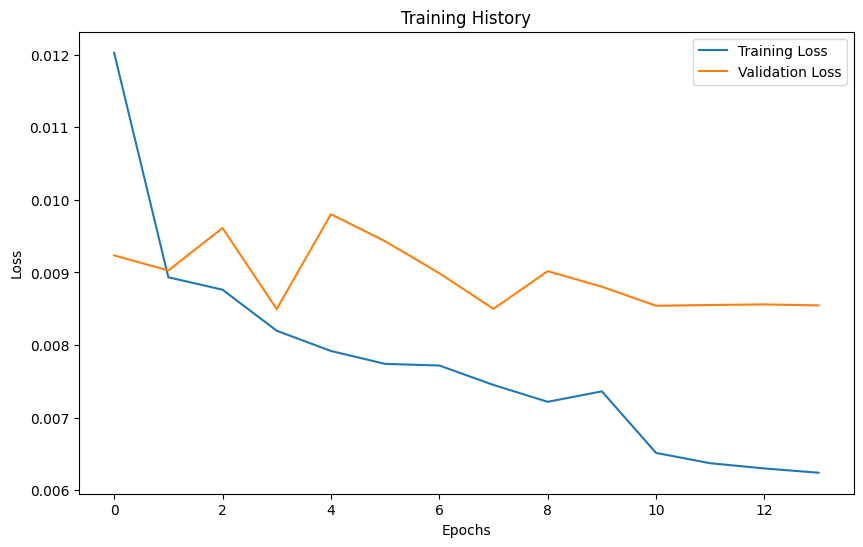

Development Set - MAE Valence: 0.0627, RMSE Valence: 0.0848, MAE Arousal: 0.0712, RMSE Arousal: 0.0992
Test Set - MAE Valence: 0.0925, RMSE Valence: 0.1203, MAE Arousal: 0.1092, RMSE Arousal: 0.1470


In [11]:
#fusion 2: 3 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=3, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Encoder layers for audio and video are not needed if we are using attention directly
        # First cross-attention layer for processing both video and audio together
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Self-attention as the second block
        self.self_attention = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        # Pad audio features to match video's sequence length
        seq_len_diff = video.size(1) - audio_norm.size(1)
        if seq_len_diff > 0:
            padding = torch.zeros((audio_norm.size(0), seq_len_diff, audio_norm.size(2)), device=audio_norm.device)
            audio_padded = torch.cat([audio_norm, padding], dim=1)
        else:
            audio_padded = audio_norm

        # First block of cross-attention
        attn_output1, _ = self.cross_attention1(video, audio_padded, audio_padded)

        # Second block of self-attention
        attn_output2, _ = self.self_attention(attn_output1, attn_output1, attn_output1)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output2.permute(0, 2, 1)).squeeze()
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion2-3sec.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")

Epoch 1, Training Loss: 0.0129
Epoch 1, Validation Loss: 0.0107
Model saved to best_model_fusion2-4sec.pth
Epoch 2, Training Loss: 0.0097
Epoch 2, Validation Loss: 0.0093
Model saved to best_model_fusion2-4sec.pth
Epoch 3, Training Loss: 0.0090
Epoch 3, Validation Loss: 0.0093
Epoch 4, Training Loss: 0.0089
Epoch 4, Validation Loss: 0.0100
Epoch 5, Training Loss: 0.0089
Epoch 5, Validation Loss: 0.0116
Epoch 6, Training Loss: 0.0087
Epoch 6, Validation Loss: 0.0100
Epoch 7, Training Loss: 0.0083
Epoch 7, Validation Loss: 0.0097
Epoch 8, Training Loss: 0.0085
Epoch 8, Validation Loss: 0.0099
Epoch 9, Training Loss: 0.0076
Epoch 9, Validation Loss: 0.0089
Model saved to best_model_fusion2-4sec.pth
Epoch 10, Training Loss: 0.0074
Epoch 10, Validation Loss: 0.0090
Epoch 11, Training Loss: 0.0074
Epoch 11, Validation Loss: 0.0089
Epoch 12, Training Loss: 0.0073
Epoch 12, Validation Loss: 0.0090
Epoch 13, Training Loss: 0.0072
Epoch 13, Validation Loss: 0.0089
Epoch 14, Training Loss: 0.0073

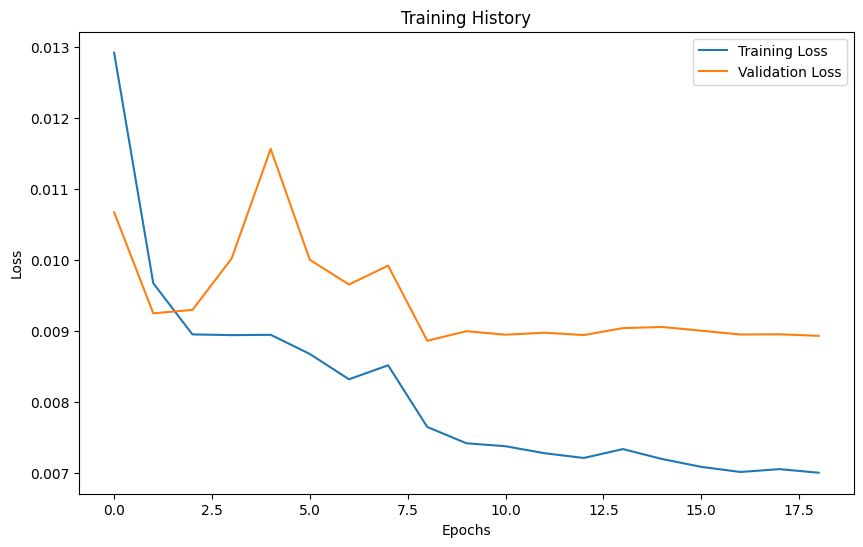

Development Set - MAE Valence: 0.0641, RMSE Valence: 0.0877, MAE Arousal: 0.0715, RMSE Arousal: 0.1009
Test Set - MAE Valence: 0.1129, RMSE Valence: 0.1494, MAE Arousal: 0.1057, RMSE Arousal: 0.1350


In [10]:
#fusion 2: 4 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.optim import Adam
from typing import Optional
import math
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out, None

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
    # x shape: [batch_size, seq_len, input_dim]
    # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

    # multi-head attention
        residual = x
        out, _ = self.self_attention(x, x, x)  # Correctly capture the output here
        x = self.add_norm_after_attention(out, residual)  # Use 'out' correctly

    # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=4, step=2):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
        
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256, num_heads=8, input_dim_video=256, input_dim_audio=768, dropout=0.1):
        super(CustomTransformer, self).__init__()
        # Normalize audio features dimensions to match video features dimensions
        self.audio_norm = nn.Linear(input_dim_audio, embed_size)
        # Encoder layers for audio and video are not needed if we are using attention directly
        # First cross-attention layer for processing both video and audio together
        self.cross_attention1 = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Self-attention as the second block
        self.self_attention = MultiHeadAttention(input_dim=embed_size, num_heads=num_heads, dropout=dropout)
        # Pooling layer
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        # Final prediction layer
        self.fc = nn.Linear(embed_size, 2)

    def forward(self, video, audio):
        # Normalize audio features to have the same dimensions as video features
        audio_norm = self.audio_norm(audio)
        # Pad audio features to match video's sequence length
        seq_len_diff = video.size(1) - audio_norm.size(1)
        if seq_len_diff > 0:
            padding = torch.zeros((audio_norm.size(0), seq_len_diff, audio_norm.size(2)), device=audio_norm.device)
            audio_padded = torch.cat([audio_norm, padding], dim=1)
        else:
            audio_padded = audio_norm

        # First block of cross-attention
        attn_output1, _ = self.cross_attention1(video, audio_padded, audio_padded)

        # Second block of self-attention
        attn_output2, _ = self.self_attention(attn_output1, attn_output1, attn_output1)

        # Pooling and prediction
        pooled_output = self.avg_pool(attn_output2.permute(0, 2, 1)).squeeze()
        predictions = self.fc(pooled_output)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion2-4sec.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10):
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")

Epoch 1, Training Loss: 0.0987
Epoch 1, Validation Loss: 0.0092
Model saved to best_model_fusion3.pth
Epoch 2, Training Loss: 0.0127
Epoch 2, Validation Loss: 0.0089
Model saved to best_model_fusion3.pth
Epoch 3, Training Loss: 0.0106
Epoch 3, Validation Loss: 0.0083
Model saved to best_model_fusion3.pth
Epoch 4, Training Loss: 0.0098
Epoch 4, Validation Loss: 0.0120
Epoch 5, Training Loss: 0.0095
Epoch 5, Validation Loss: 0.0094
Epoch 6, Training Loss: 0.0089
Epoch 6, Validation Loss: 0.0157
Epoch 7, Training Loss: 0.0093
Epoch 7, Validation Loss: 0.0125
Epoch 8, Training Loss: 0.0086
Epoch 8, Validation Loss: 0.0091
Epoch 9, Training Loss: 0.0088
Epoch 9, Validation Loss: 0.0104
Epoch 10, Training Loss: 0.0073
Epoch 10, Validation Loss: 0.0080
Model saved to best_model_fusion3.pth
Epoch 11, Training Loss: 0.0071
Epoch 11, Validation Loss: 0.0078
Model saved to best_model_fusion3.pth
Epoch 12, Training Loss: 0.0070
Epoch 12, Validation Loss: 0.0079
Epoch 13, Training Loss: 0.0070
Epoc

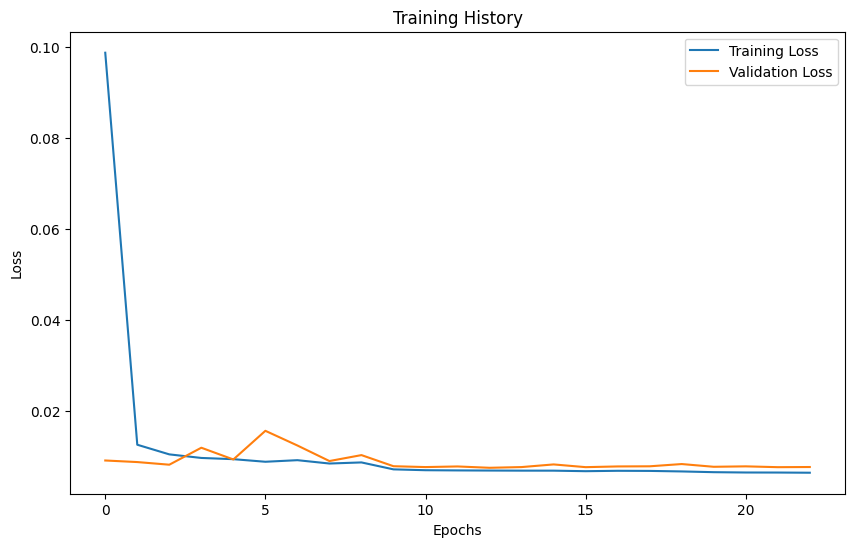

Development Set - MAE Valence: 0.0602, RMSE Valence: 0.0820, MAE Arousal: 0.0667, RMSE Arousal: 0.0940
Test Set - MAE Valence: 0.0923, RMSE Valence: 0.1201, MAE Arousal: 0.1033, RMSE Arousal: 0.1327


In [13]:
#fusion 3: 2 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
import math
from typing import Optional
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

        # multi-head attention
        residual = x
        x = self.self_attention(x, x, x)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=2, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
# Custom Model
class CustomSelfAttentionTransformer(nn.Module):
    def __init__(self, embed_size=256, heads=8, num_layers=2, dropout=0.1):
        super(CustomSelfAttentionTransformer, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.num_layers = num_layers
        
        # Normalize audio features to have the same dimension as video features
        self.audio_norm = nn.Linear(768, embed_size)
        
        # Transformer Encoder Layers for self-attention
        # Use your custom EncoderLayer for consistency with your transformer architecture
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(input_dim=embed_size, num_heads=heads, dropout=dropout, positional_encoding=True)
            for _ in range(num_layers)
        ])
        
        # Optionally, add a second set of Transformer Encoder Layers for deeper processing
        # This is the second self-attention block
        self.second_encoder_layers = nn.ModuleList([
            EncoderLayer(input_dim=embed_size, num_heads=heads, dropout=dropout, positional_encoding=False)  # Positional encoding only at the first block
            for _ in range(num_layers)
        ])
        
        # Adaptive average pooling to convert the sequence of features to a single feature vector per sample
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layer for final prediction
        self.fc = nn.Linear(embed_size, 2)  # Predict valence and arousal

    def forward(self, video, audio):
        # Normalize audio features to match video feature size
        audio = self.audio_norm(audio)

        # Concatenate audio and video features along the sequence dimension
        combined_features = torch.cat((video, audio), dim=1)

        # Apply self-attention using transformer encoder layers
        for layer in self.encoder_layers:
            combined_features = layer(combined_features)

        # Apply the second block of self-attention
        for layer in self.second_encoder_layers:
            combined_features = layer(combined_features)

        # Pooling and prediction
        combined_features = combined_features.permute(0, 2, 1)  # (batch, channels, seq_len)
        pooled_output = self.avg_pool(combined_features).squeeze()
        predictions = self.fc(pooled_output)

        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomSelfAttentionTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion3.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.1018
Epoch 1, Validation Loss: 0.0153
Model saved to best_model_fusion3.pth
Epoch 2, Training Loss: 0.0141
Epoch 2, Validation Loss: 0.0089
Model saved to best_model_fusion3.pth
Epoch 3, Training Loss: 0.0117
Epoch 3, Validation Loss: 0.0119
Epoch 4, Training Loss: 0.0111
Epoch 4, Validation Loss: 0.0097
Epoch 5, Training Loss: 0.0103
Epoch 5, Validation Loss: 0.0095
Epoch 6, Training Loss: 0.0104
Epoch 6, Validation Loss: 0.0081
Model saved to best_model_fusion3.pth
Epoch 7, Training Loss: 0.0095
Epoch 7, Validation Loss: 0.0078
Model saved to best_model_fusion3.pth
Epoch 8, Training Loss: 0.0090
Epoch 8, Validation Loss: 0.0083
Epoch 9, Training Loss: 0.0088
Epoch 9, Validation Loss: 0.0092
Epoch 10, Training Loss: 0.0087
Epoch 10, Validation Loss: 0.0088
Epoch 11, Training Loss: 0.0087
Epoch 11, Validation Loss: 0.0084
Epoch 12, Training Loss: 0.0088
Epoch 12, Validation Loss: 0.0086
Epoch 13, Training Loss: 0.0090
Epoch 13, Validation Loss: 0.0120
Epoch 14

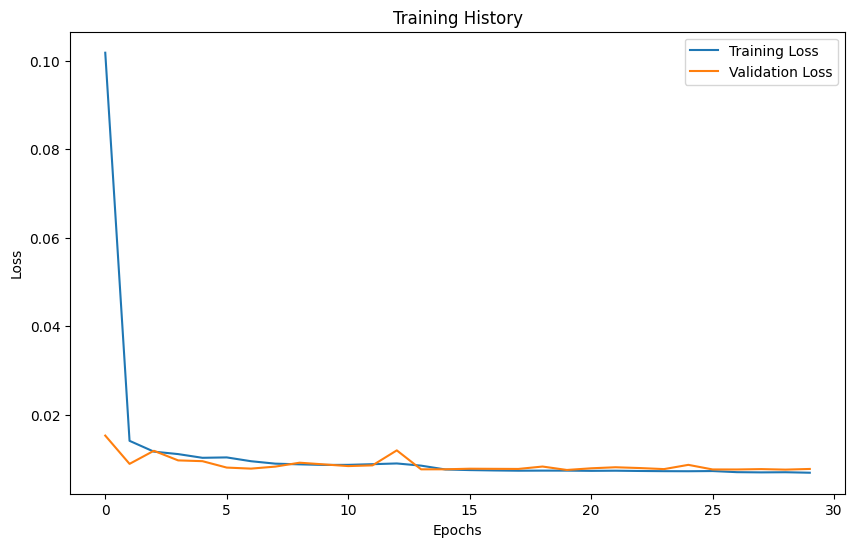

Development Set - MAE Valence: 0.0594, RMSE Valence: 0.0814, MAE Arousal: 0.0666, RMSE Arousal: 0.0943
Test Set - MAE Valence: 0.0940, RMSE Valence: 0.1232, MAE Arousal: 0.1021, RMSE Arousal: 0.1289


In [4]:
#fusion 3: 1 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
import math
from typing import Optional
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

        # multi-head attention
        residual = x
        x = self.self_attention(x, x, x)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=1, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
# Custom Model
class CustomSelfAttentionTransformer(nn.Module):
    def __init__(self, embed_size=256, heads=8, num_layers=2, dropout=0.1):
        super(CustomSelfAttentionTransformer, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.num_layers = num_layers
        
        # Normalize audio features to have the same dimension as video features
        self.audio_norm = nn.Linear(768, embed_size)
        
        # Transformer Encoder Layers for self-attention
        # Use your custom EncoderLayer for consistency with your transformer architecture
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(input_dim=embed_size, num_heads=heads, dropout=dropout, positional_encoding=True)
            for _ in range(num_layers)
        ])
        
        # Optionally, add a second set of Transformer Encoder Layers for deeper processing
        # This is the second self-attention block
        self.second_encoder_layers = nn.ModuleList([
            EncoderLayer(input_dim=embed_size, num_heads=heads, dropout=dropout, positional_encoding=False)  # Positional encoding only at the first block
            for _ in range(num_layers)
        ])
        
        # Adaptive average pooling to convert the sequence of features to a single feature vector per sample
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layer for final prediction
        self.fc = nn.Linear(embed_size, 2)  # Predict valence and arousal

    def forward(self, video, audio):
        # Normalize audio features to match video feature size
        audio = self.audio_norm(audio)

        # Concatenate audio and video features along the sequence dimension
        combined_features = torch.cat((video, audio), dim=1)

        # Apply self-attention using transformer encoder layers
        for layer in self.encoder_layers:
            combined_features = layer(combined_features)

        # Apply the second block of self-attention
        for layer in self.second_encoder_layers:
            combined_features = layer(combined_features)

        # Pooling and prediction
        combined_features = combined_features.permute(0, 2, 1)  # (batch, channels, seq_len)
        pooled_output = self.avg_pool(combined_features).squeeze()
        predictions = self.fc(pooled_output)

        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomSelfAttentionTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion3.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")

Epoch 1, Training Loss: 0.0918
Epoch 1, Validation Loss: 0.0104
Model saved to best_model_fusion3.pth
Epoch 2, Training Loss: 0.0107
Epoch 2, Validation Loss: 0.0090
Model saved to best_model_fusion3.pth
Epoch 3, Training Loss: 0.0103
Epoch 3, Validation Loss: 0.0099
Epoch 4, Training Loss: 0.0107
Epoch 4, Validation Loss: 0.0163
Epoch 5, Training Loss: 0.0094
Epoch 5, Validation Loss: 0.0103
Epoch 6, Training Loss: 0.0090
Epoch 6, Validation Loss: 0.0080
Model saved to best_model_fusion3.pth
Epoch 7, Training Loss: 0.0087
Epoch 7, Validation Loss: 0.0084
Epoch 8, Training Loss: 0.0090
Epoch 8, Validation Loss: 0.0092
Epoch 9, Training Loss: 0.0087
Epoch 9, Validation Loss: 0.0090
Epoch 10, Training Loss: 0.0085
Epoch 10, Validation Loss: 0.0088
Epoch 11, Training Loss: 0.0084
Epoch 11, Validation Loss: 0.0120
Epoch 12, Training Loss: 0.0080
Epoch 12, Validation Loss: 0.0083
Epoch 13, Training Loss: 0.0065
Epoch 13, Validation Loss: 0.0075
Model saved to best_model_fusion3.pth
Epoch 14

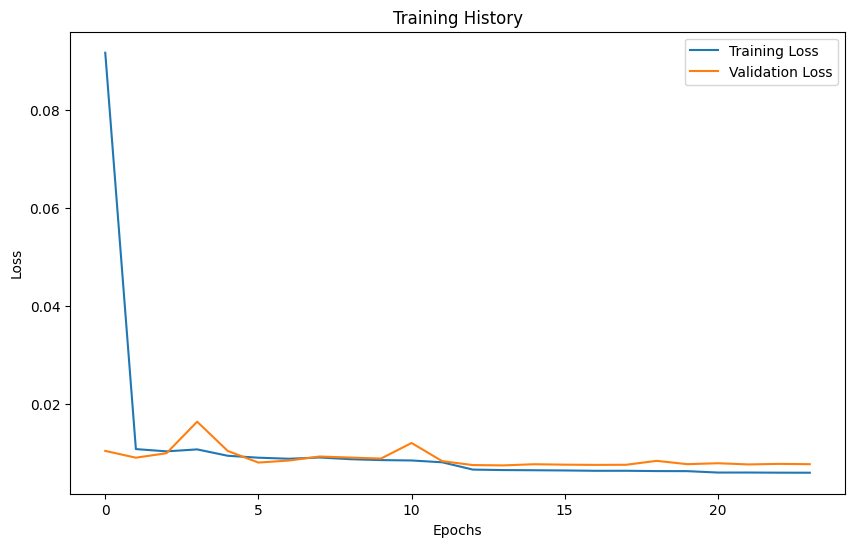

Development Set - MAE Valence: 0.0602, RMSE Valence: 0.0816, MAE Arousal: 0.0661, RMSE Arousal: 0.0924
Test Set - MAE Valence: 0.0914, RMSE Valence: 0.1193, MAE Arousal: 0.1013, RMSE Arousal: 0.1292


In [5]:
#fusion 3: 3 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
import math
from typing import Optional
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

        # multi-head attention
        residual = x
        x = self.self_attention(x, x, x)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=3, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
# Custom Model
class CustomSelfAttentionTransformer(nn.Module):
    def __init__(self, embed_size=256, heads=8, num_layers=2, dropout=0.1):
        super(CustomSelfAttentionTransformer, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.num_layers = num_layers
        
        # Normalize audio features to have the same dimension as video features
        self.audio_norm = nn.Linear(768, embed_size)
        
        # Transformer Encoder Layers for self-attention
        # Use your custom EncoderLayer for consistency with your transformer architecture
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(input_dim=embed_size, num_heads=heads, dropout=dropout, positional_encoding=True)
            for _ in range(num_layers)
        ])
        
        # Optionally, add a second set of Transformer Encoder Layers for deeper processing
        # This is the second self-attention block
        self.second_encoder_layers = nn.ModuleList([
            EncoderLayer(input_dim=embed_size, num_heads=heads, dropout=dropout, positional_encoding=False)  # Positional encoding only at the first block
            for _ in range(num_layers)
        ])
        
        # Adaptive average pooling to convert the sequence of features to a single feature vector per sample
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layer for final prediction
        self.fc = nn.Linear(embed_size, 2)  # Predict valence and arousal

    def forward(self, video, audio):
        # Normalize audio features to match video feature size
        audio = self.audio_norm(audio)

        # Concatenate audio and video features along the sequence dimension
        combined_features = torch.cat((video, audio), dim=1)

        # Apply self-attention using transformer encoder layers
        for layer in self.encoder_layers:
            combined_features = layer(combined_features)

        # Apply the second block of self-attention
        for layer in self.second_encoder_layers:
            combined_features = layer(combined_features)

        # Pooling and prediction
        combined_features = combined_features.permute(0, 2, 1)  # (batch, channels, seq_len)
        pooled_output = self.avg_pool(combined_features).squeeze()
        predictions = self.fc(pooled_output)

        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomSelfAttentionTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion3.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
    
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.1988
Epoch 1, Validation Loss: 0.0218
Model saved to best_model_fusion3.pth
Epoch 2, Training Loss: 0.0166
Epoch 2, Validation Loss: 0.0126
Model saved to best_model_fusion3.pth
Epoch 3, Training Loss: 0.0128
Epoch 3, Validation Loss: 0.0115
Model saved to best_model_fusion3.pth
Epoch 4, Training Loss: 0.0106
Epoch 4, Validation Loss: 0.0097
Model saved to best_model_fusion3.pth
Epoch 5, Training Loss: 0.0109
Epoch 5, Validation Loss: 0.0113
Epoch 6, Training Loss: 0.0102
Epoch 6, Validation Loss: 0.0075
Model saved to best_model_fusion3.pth
Epoch 7, Training Loss: 0.0098
Epoch 7, Validation Loss: 0.0081
Epoch 8, Training Loss: 0.0092
Epoch 8, Validation Loss: 0.0092
Epoch 9, Training Loss: 0.0094
Epoch 9, Validation Loss: 0.0128
Epoch 10, Training Loss: 0.0088
Epoch 10, Validation Loss: 0.0098
Epoch 11, Training Loss: 0.0086
Epoch 11, Validation Loss: 0.0079
Epoch 12, Training Loss: 0.0088
Epoch 12, Validation Loss: 0.0089
Epoch 13, Training Loss: 0.0072
Epoc

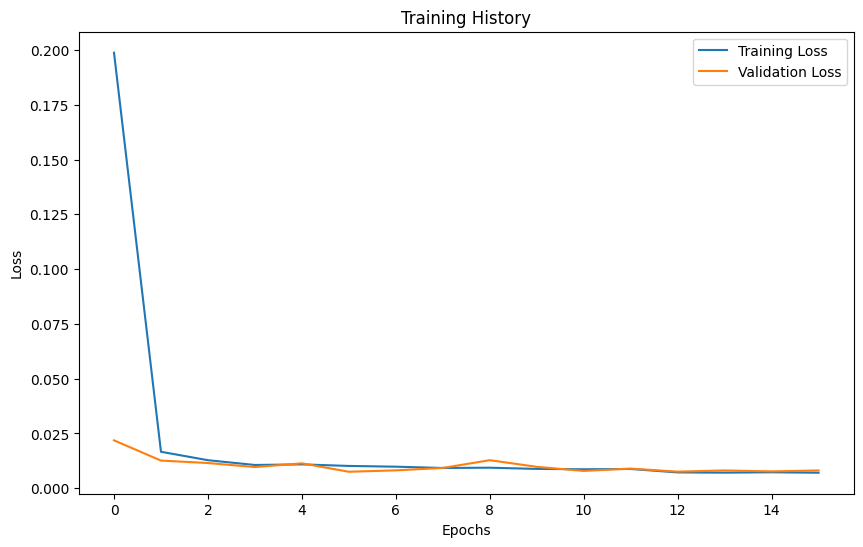

Development Set - MAE Valence: 0.0661, RMSE Valence: 0.0892, MAE Arousal: 0.0639, RMSE Arousal: 0.0904
Test Set - MAE Valence: 0.0902, RMSE Valence: 0.1174, MAE Arousal: 0.0988, RMSE Arousal: 0.1284


In [9]:
#fusion 3: 4 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
import math
from typing import Optional
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

class ScaledDotProductAttention_MultiHead(nn.Module):

    def __init__(self):
        super(ScaledDotProductAttention_MultiHead, self).__init__()
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, query, key, value, mask=None):
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # key, query, value shapes: [batch_size, num_heads, seq_len, dim]
        emb_dim = key.shape[-1]

        # Calculate attention weights
        attention_weights = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(emb_dim)

        # masking
        if mask is not None:
            raise ValueError("Mask is not supported yet")

        # Softmax
        attention_weights = self.softmax(attention_weights)

        # modify value
        value = torch.matmul(attention_weights, value)

        return value, attention_weights


class PositionWiseFeedForward(nn.Module):

    def __init__(self, input_dim, hidden_dim, dropout:float=0.1):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, input_dim)
        self.layer_norm= nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # feed-forward network
        x = self.layer_1(x)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.layer_2(x)

        return x


class Add_and_Norm(nn.Module):

    def __init__(self, input_dim, dropout:Optional[float]=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(input_dim)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)


    def forward(self, x1, residual):
        x = x1
        # apply dropout of needed
        if hasattr(self, "dropout"):
            x = self.dropout(x)
        # add and then norm
        x = x + residual
        x = self.layer_norm(x)

        return x



class MultiHeadAttention(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1):
        super().__init__()
        self.input_dim = input_dim
        self.num_heads = num_heads
        if input_dim % num_heads != 0:
            raise ValueError("input_dim must be divisible by num_heads")
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize weights
        self.query_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.keys_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.values_w = nn.Linear(input_dim, self.num_heads * self.head_dim, bias=False)
        self.ff_layer_after_concat = nn.Linear(self.num_heads * self.head_dim, input_dim, bias=False)

        self.attention = ScaledDotProductAttention_MultiHead()

        if self.dropout is not None:
            self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, mask=None):
        # query, keys, values shapes: [batch_size, seq_len, input_dim]
        batch_size, len_query, len_keys, len_values = queries.size(0), queries.size(1), keys.size(1), values.size(1)

        # linear transformation before attention
        queries = self.query_w(queries).view(batch_size, len_query, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        keys = self.keys_w(keys).view(batch_size, len_keys, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]
        values = self.values_w(values).view(batch_size, len_values, self.num_heads, self.head_dim).transpose(1, 2) # [batch_size, num_heads, seq_len, dim]

        # attention itself
        values, attention_weights = self.attention(queries, keys, values, mask=mask) # values shape:[batch_size, num_heads, seq_len, dim]

        # concatenation
        out = values.transpose(1, 2).contiguous().view(batch_size, len_values, self.num_heads * self.head_dim) # [batch_size, seq_len, num_heads * dim = input_dim]
        # go through last linear layer
        out = self.ff_layer_after_concat(out)

        return out

class EncoderLayer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(EncoderLayer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            x = self.positional_encoding(x)

        # multi-head attention
        residual = x
        x = self.self_attention(x, x, x)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x



class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe=pe.permute(1, 0, 2) # [seq_len, batch_size, embedding_dim] -> [batch_size, seq_len, embedding_dim]
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: Tensor, shape [batch_size, seq_len, embedding_dim]
        """
        x = x + self.pe[:,:x.size(1)]
        return self.dropout(x)



class Transformer_layer(nn.Module):

    def __init__(self, input_dim, num_heads, dropout:Optional[float]=0.1, positional_encoding:bool=True):
        super(Transformer_layer, self).__init__()
        self.positional_encoding = positional_encoding
        self.input_dim = input_dim
        self.num_heads = num_heads
        self.head_dim = input_dim // num_heads
        self.dropout = dropout

        # initialize layers
        self.self_attention = MultiHeadAttention(input_dim, num_heads, dropout=dropout)
        self.feed_forward = PositionWiseFeedForward(input_dim, input_dim, dropout=dropout)
        self.add_norm_after_attention = Add_and_Norm(input_dim, dropout=dropout)
        self.add_norm_after_ff = Add_and_Norm(input_dim, dropout=dropout)

        # calculate positional encoding
        if self.positional_encoding:
            self.positional_encoding = PositionalEncoding(input_dim)



    def forward(self, key, value, query, mask=None):
        # key, value, and query shapes: [batch_size, seq_len, input_dim]
        # positional encoding
        if self.positional_encoding:
            key = self.positional_encoding(key)
            value = self.positional_encoding(value)
            query = self.positional_encoding(query)

        # multi-head attention
        residual = query
        x = self.self_attention(queries=query, keys=key, values=value, mask=mask)
        x = self.add_norm_after_attention(x, residual)

        # feed forward
        residual = x
        x = self.feed_forward(x)
        x = self.add_norm_after_ff(x, residual)

        return x

# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=4, step=2):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
# Custom Model
class CustomSelfAttentionTransformer(nn.Module):
    def __init__(self, embed_size=256, heads=8, num_layers=2, dropout=0.1):
        super(CustomSelfAttentionTransformer, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.num_layers = num_layers
        
        # Normalize audio features to have the same dimension as video features
        self.audio_norm = nn.Linear(768, embed_size)
        
        # Transformer Encoder Layers for self-attention
        # Use your custom EncoderLayer for consistency with your transformer architecture
        self.encoder_layers = nn.ModuleList([
            EncoderLayer(input_dim=embed_size, num_heads=heads, dropout=dropout, positional_encoding=True)
            for _ in range(num_layers)
        ])
        
        # Optionally, add a second set of Transformer Encoder Layers for deeper processing
        # This is the second self-attention block
        self.second_encoder_layers = nn.ModuleList([
            EncoderLayer(input_dim=embed_size, num_heads=heads, dropout=dropout, positional_encoding=False)  # Positional encoding only at the first block
            for _ in range(num_layers)
        ])
        
        # Adaptive average pooling to convert the sequence of features to a single feature vector per sample
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layer for final prediction
        self.fc = nn.Linear(embed_size, 2)  # Predict valence and arousal

    def forward(self, video, audio):
        # Normalize audio features to match video feature size
        audio = self.audio_norm(audio)

        # Concatenate audio and video features along the sequence dimension
        combined_features = torch.cat((video, audio), dim=1)

        # Apply self-attention using transformer encoder layers
        for layer in self.encoder_layers:
            combined_features = layer(combined_features)

        # Apply the second block of self-attention
        for layer in self.second_encoder_layers:
            combined_features = layer(combined_features)

        # Pooling and prediction
        combined_features = combined_features.permute(0, 2, 1)  # (batch, channels, seq_len)
        pooled_output = self.avg_pool(combined_features).squeeze()
        predictions = self.fc(pooled_output)

        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomSelfAttentionTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion3.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0092
Epoch 1, Validation Loss: 0.0083
Model saved to best_model_fusion4.pth
Epoch 2, Training Loss: 0.0081
Epoch 2, Validation Loss: 0.0082
Model saved to best_model_fusion4.pth
Epoch 3, Training Loss: 0.0079
Epoch 3, Validation Loss: 0.0082
Epoch 4, Training Loss: 0.0076
Epoch 4, Validation Loss: 0.0087
Epoch 5, Training Loss: 0.0074
Epoch 5, Validation Loss: 0.0088
Epoch 6, Training Loss: 0.0074
Epoch 6, Validation Loss: 0.0086
Epoch 7, Training Loss: 0.0072
Epoch 7, Validation Loss: 0.0085
Epoch 8, Training Loss: 0.0071
Epoch 8, Validation Loss: 0.0084
Epoch 9, Training Loss: 0.0066
Epoch 9, Validation Loss: 0.0082
Model saved to best_model_fusion4.pth
Epoch 10, Training Loss: 0.0065
Epoch 10, Validation Loss: 0.0081
Model saved to best_model_fusion4.pth
Epoch 11, Training Loss: 0.0065
Epoch 11, Validation Loss: 0.0083
Epoch 12, Training Loss: 0.0064
Epoch 12, Validation Loss: 0.0082
Epoch 13, Training Loss: 0.0064
Epoch 13, Validation Loss: 0.0082
Epoch 14

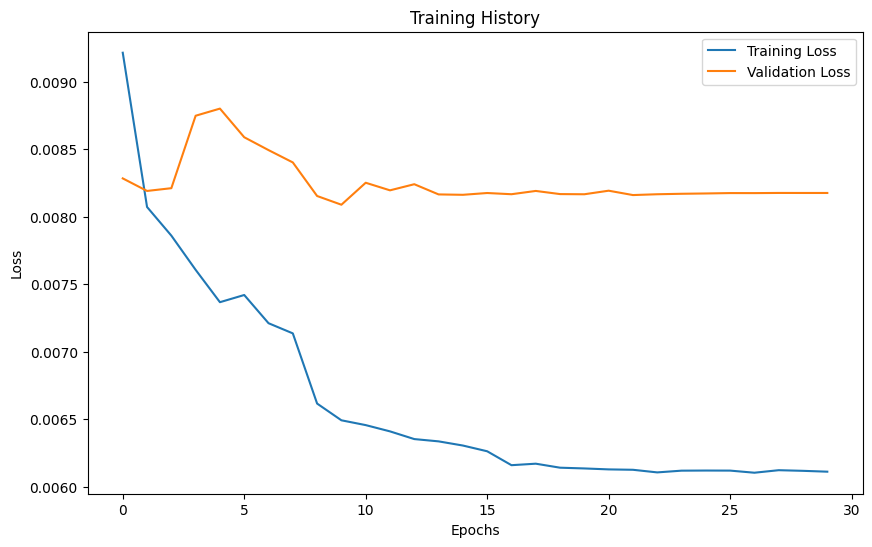

Development Set - MAE Valence: 0.0606, RMSE Valence: 0.0830, MAE Arousal: 0.0689, RMSE Arousal: 0.0972
Test Set - MAE Valence: 0.0876, RMSE Valence: 0.1113, MAE Arousal: 0.0944, RMSE Arousal: 0.1213


In [14]:
#fusion 4: 2 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
        
# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=2, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
# Custom Model
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256):
        super(CustomTransformer, self).__init__()
        #we're directly pooling and then concatenating audio and video
        self.avg_pool_video = nn.AdaptiveAvgPool1d(1)  # Pool video to a single vector
        self.avg_pool_audio = nn.AdaptiveAvgPool1d(1)  # Pool audio to a single vector
        self.fc1 = nn.Linear(768 + 256, embed_size)  # Concatenated audio and video features to embed_size
        self.fc2 = nn.Linear(embed_size, 2)  # Predict valence and arousal

    def forward(self, video, audio):
        # Average pooling across timesteps for both audio and video
        video_pooled = self.avg_pool_video(video.permute(0, 2, 1)).squeeze()
        audio_pooled = self.avg_pool_audio(audio.permute(0, 2, 1)).squeeze()
        
        # Concatenate pooled audio and video features
        concatenated_features = torch.cat((video_pooled, audio_pooled), dim=1)
        
        # Normalize concatenated features to have the same dimension as embed_size
        normalized_features = F.relu(self.fc1(concatenated_features))
        
        # Predictions
        predictions = self.fc2(normalized_features)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration , 2 is better cause of batch normalization
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion4.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=20): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0097
Epoch 1, Validation Loss: 0.0097
Model saved to best_model_fusion4.pth
Epoch 2, Training Loss: 0.0080
Epoch 2, Validation Loss: 0.0078
Model saved to best_model_fusion4.pth
Epoch 3, Training Loss: 0.0078
Epoch 3, Validation Loss: 0.0087
Epoch 4, Training Loss: 0.0076
Epoch 4, Validation Loss: 0.0084
Epoch 5, Training Loss: 0.0074
Epoch 5, Validation Loss: 0.0084
Epoch 6, Training Loss: 0.0073
Epoch 6, Validation Loss: 0.0078
Epoch 7, Training Loss: 0.0072
Epoch 7, Validation Loss: 0.0081
Epoch 8, Training Loss: 0.0072
Epoch 8, Validation Loss: 0.0079
Epoch 9, Training Loss: 0.0067
Epoch 9, Validation Loss: 0.0079
Epoch 10, Training Loss: 0.0066
Epoch 10, Validation Loss: 0.0078
Epoch 11, Training Loss: 0.0066
Epoch 11, Validation Loss: 0.0079
Epoch 12, Training Loss: 0.0065
Epoch 12, Validation Loss: 0.0079
Early stopping triggered


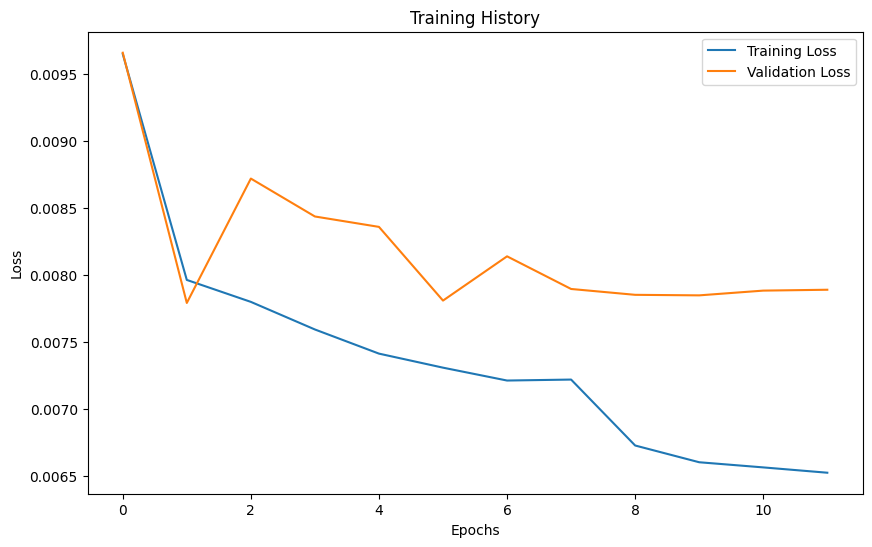

Development Set - MAE Valence: 0.0597, RMSE Valence: 0.0811, MAE Arousal: 0.0680, RMSE Arousal: 0.0958
Test Set - MAE Valence: 0.0893, RMSE Valence: 0.1145, MAE Arousal: 0.0930, RMSE Arousal: 0.1183


In [15]:
#fusion 4 1 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
        
# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=1, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
# Custom Model
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256):
        super(CustomTransformer, self).__init__()
        #we're directly pooling and then concatenating audio and video
        self.avg_pool_video = nn.AdaptiveAvgPool1d(1)  # Pool video to a single vector
        self.avg_pool_audio = nn.AdaptiveAvgPool1d(1)  # Pool audio to a single vector
        self.fc1 = nn.Linear(768 + 256, embed_size)  # Concatenated audio and video features to embed_size
        self.fc2 = nn.Linear(embed_size, 2)  # Predict valence and arousal

    def forward(self, video, audio):
        # Average pooling across timesteps for both audio and video
        video_pooled = self.avg_pool_video(video.permute(0, 2, 1)).squeeze()
        audio_pooled = self.avg_pool_audio(audio.permute(0, 2, 1)).squeeze()
        
        # Concatenate pooled audio and video features
        concatenated_features = torch.cat((video_pooled, audio_pooled), dim=1)
        
        # Normalize concatenated features to have the same dimension as embed_size
        normalized_features = F.relu(self.fc1(concatenated_features))
        
        # Predictions
        predictions = self.fc2(normalized_features)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration , 2 is better cause of batch normalization
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion4.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
                
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0097
Epoch 1, Validation Loss: 0.0087
Model saved to best_model_fusion4.pth
Epoch 2, Training Loss: 0.0084
Epoch 2, Validation Loss: 0.0101
Epoch 3, Training Loss: 0.0080
Epoch 3, Validation Loss: 0.0088
Epoch 4, Training Loss: 0.0078
Epoch 4, Validation Loss: 0.0087
Model saved to best_model_fusion4.pth
Epoch 5, Training Loss: 0.0077
Epoch 5, Validation Loss: 0.0093
Epoch 6, Training Loss: 0.0076
Epoch 6, Validation Loss: 0.0101
Epoch 7, Training Loss: 0.0075
Epoch 7, Validation Loss: 0.0088
Epoch 8, Training Loss: 0.0073
Epoch 8, Validation Loss: 0.0087
Epoch 9, Training Loss: 0.0072
Epoch 9, Validation Loss: 0.0089
Epoch 10, Training Loss: 0.0071
Epoch 10, Validation Loss: 0.0088
Epoch 11, Training Loss: 0.0065
Epoch 11, Validation Loss: 0.0086
Model saved to best_model_fusion4.pth
Epoch 12, Training Loss: 0.0064
Epoch 12, Validation Loss: 0.0088
Epoch 13, Training Loss: 0.0064
Epoch 13, Validation Loss: 0.0091
Epoch 14, Training Loss: 0.0063
Epoch 14, Vali

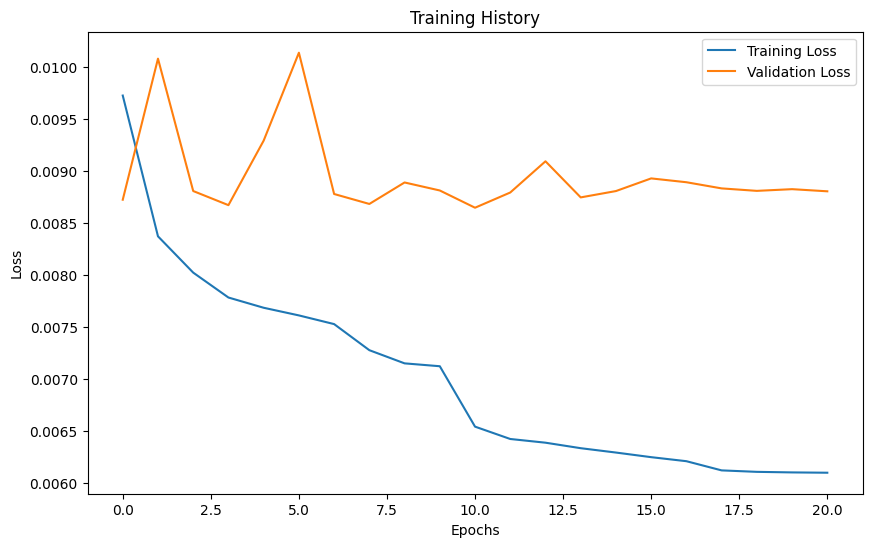

Development Set - MAE Valence: 0.0626, RMSE Valence: 0.0857, MAE Arousal: 0.0718, RMSE Arousal: 0.1009
Test Set - MAE Valence: 0.0923, RMSE Valence: 0.1174, MAE Arousal: 0.0975, RMSE Arousal: 0.1246


In [17]:
#fusion 4 3 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
        
# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=3, step=1):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
# Custom Model
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256):
        super(CustomTransformer, self).__init__()
        #we're directly pooling and then concatenating audio and video
        self.avg_pool_video = nn.AdaptiveAvgPool1d(1)  # Pool video to a single vector
        self.avg_pool_audio = nn.AdaptiveAvgPool1d(1)  # Pool audio to a single vector
        self.fc1 = nn.Linear(768 + 256, embed_size)  # Concatenated audio and video features to embed_size
        self.fc2 = nn.Linear(embed_size, 2)  # Predict valence and arousal

    def forward(self, video, audio):
        # Average pooling across timesteps for both audio and video
        video_pooled = self.avg_pool_video(video.permute(0, 2, 1)).squeeze()
        audio_pooled = self.avg_pool_audio(audio.permute(0, 2, 1)).squeeze()
        
        # Concatenate pooled audio and video features
        concatenated_features = torch.cat((video_pooled, audio_pooled), dim=1)
        
        # Normalize concatenated features to have the same dimension as embed_size
        normalized_features = F.relu(self.fc1(concatenated_features))
        
        # Predictions
        predictions = self.fc2(normalized_features)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration , 2 is better cause of batch normalization
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion4.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
    return train_losses, val_losses
    
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")


Epoch 1, Training Loss: 0.0109
Epoch 1, Validation Loss: 0.0094
Model saved to best_model_fusion4.pth
Epoch 2, Training Loss: 0.0089
Epoch 2, Validation Loss: 0.0124
Epoch 3, Training Loss: 0.0090
Epoch 3, Validation Loss: 0.0092
Model saved to best_model_fusion4.pth
Epoch 4, Training Loss: 0.0083
Epoch 4, Validation Loss: 0.0092
Epoch 5, Training Loss: 0.0082
Epoch 5, Validation Loss: 0.0091
Model saved to best_model_fusion4.pth
Epoch 6, Training Loss: 0.0080
Epoch 6, Validation Loss: 0.0095
Epoch 7, Training Loss: 0.0078
Epoch 7, Validation Loss: 0.0090
Model saved to best_model_fusion4.pth
Epoch 8, Training Loss: 0.0077
Epoch 8, Validation Loss: 0.0090
Model saved to best_model_fusion4.pth
Epoch 9, Training Loss: 0.0077
Epoch 9, Validation Loss: 0.0091
Epoch 10, Training Loss: 0.0077
Epoch 10, Validation Loss: 0.0093
Epoch 11, Training Loss: 0.0075
Epoch 11, Validation Loss: 0.0092
Epoch 12, Training Loss: 0.0075
Epoch 12, Validation Loss: 0.0104
Epoch 13, Training Loss: 0.0076
Epoc

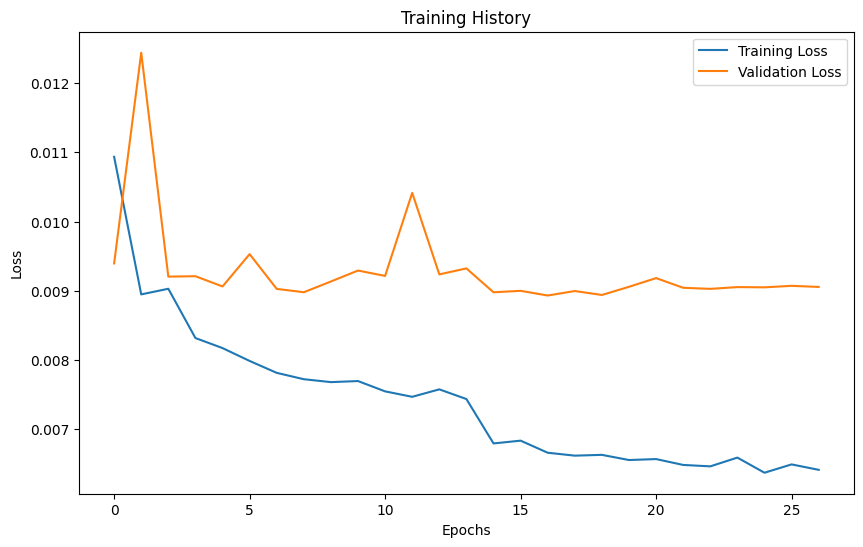

Development Set - MAE Valence: 0.0642, RMSE Valence: 0.0888, MAE Arousal: 0.0718, RMSE Arousal: 0.1010
Test Set - MAE Valence: 0.0941, RMSE Valence: 0.1197, MAE Arousal: 0.0999, RMSE Arousal: 0.1297


In [18]:
#fusion 4 4 sec
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.functional import mse_loss
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
        
# Custom DataLoader
class SynchronizedAudioVideoDataset(Dataset):
    def __init__(self, video_df, audio_df, window_length=4, step=2):
        self.video_df = video_df
        self.audio_df = audio_df
        self.window_length = window_length
        self.step = step
        self.max_frames = window_length * 3
        self.data = self._synchronize()

    def _extract_video_id(self, path):
        return path.split('/')[-1].split('_')[0]
        
    def _synchronize(self):
        synchronized_data = []
        video_ids = self.video_df['path'].apply(self._extract_video_id).unique()
        
        for video_id in video_ids:
            video_data = self.video_df[self.video_df['path'].apply(lambda x: self._extract_video_id(x) == video_id)]
            audio_data = self.audio_df[self.audio_df['filename'].str.contains(video_id)]

            start_time = 0
            while True:
                end_time = start_time + self.window_length
                window_video_data = video_data[(video_data['timestamp'] >= start_time) & (video_data['timestamp'] < end_time)]
                window_audio_data = audio_data[(audio_data['start_timestep'] >= start_time) & (audio_data['end_timestep'] <= end_time)]

                if len(window_video_data) > 0 and len(window_audio_data) > 0:
                    if len(window_video_data) < self.max_frames:
                        additional_rows = self.max_frames - len(window_video_data)
                        last_row = window_video_data.iloc[-1:].copy()
                        for _ in range(additional_rows):
                            window_video_data = pd.concat([window_video_data, last_row], ignore_index=True)

                    labels = window_video_data.iloc[-1][['arousal', 'valence']].values
                    video_features = window_video_data.iloc[:, 4:].values
                    audio_features = window_audio_data.iloc[:, 6:].values

                    video_name = video_id
                    timestamp = window_video_data.iloc[-1]['timestamp']

                    synchronized_data.append((video_features, audio_features, labels, video_name, timestamp))

                start_time += self.step
                if start_time + self.window_length > video_data['timestamp'].max():
                    break

        return synchronized_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        video_features, audio_features, labels, video_name, timestamp = self.data[idx]
        
        # Ensure labels are in a consistent format
        labels = np.array(labels, dtype=np.float32)

        video_features_tensor = torch.tensor(video_features, dtype=torch.float32)
        audio_features_tensor = torch.tensor(audio_features, dtype=torch.float32)
        labels_tensor = torch.tensor(labels, dtype=torch.float32)

        #print(f"Video features type: {type(video_features)}, shape: {video_features.shape}")
        #print(f"Audio features type: {type(audio_features)}, shape: {audio_features.shape}")
        #print(f"Labels type: {type(labels)}, shape: {labels.shape}")

        return video_features_tensor, audio_features_tensor, labels_tensor, video_name, timestamp
        
# Custom Model
class CustomTransformer(nn.Module):
    def __init__(self, embed_size=256):
        super(CustomTransformer, self).__init__()
        #we're directly pooling and then concatenating audio and video
        self.avg_pool_video = nn.AdaptiveAvgPool1d(1)  # Pool video to a single vector
        self.avg_pool_audio = nn.AdaptiveAvgPool1d(1)  # Pool audio to a single vector
        self.fc1 = nn.Linear(768 + 256, embed_size)  # Concatenated audio and video features to embed_size
        self.fc2 = nn.Linear(embed_size, 2)  # Predict valence and arousal

    def forward(self, video, audio):
        # Average pooling across timesteps for both audio and video
        video_pooled = self.avg_pool_video(video.permute(0, 2, 1)).squeeze()
        audio_pooled = self.avg_pool_audio(audio.permute(0, 2, 1)).squeeze()
        
        # Concatenate pooled audio and video features
        concatenated_features = torch.cat((video_pooled, audio_pooled), dim=1)
        
        # Normalize concatenated features to have the same dimension as embed_size
        normalized_features = F.relu(self.fc1(concatenated_features))
        
        # Predictions
        predictions = self.fc2(normalized_features)
        
        return predictions

# Load video and audio data
video_train_df = pd.read_csv('SEWA_radiant_fog_160_train.csv')
video_dev_df = pd.read_csv('SEWA_radiant_fog_160_dev.csv')
video_test_df = pd.read_csv('SEWA_radiant_fog_160_test.csv')

audio_train_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_train.csv')
audio_dev_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_dev.csv')
audio_test_df = pd.read_csv('1sec/SEWA_features_wav2vec_1_seconds_test.csv')

# Create dataset instances
train_dataset = SynchronizedAudioVideoDataset(video_train_df, audio_train_df)
dev_dataset = SynchronizedAudioVideoDataset(video_dev_df, audio_dev_df)
test_dataset = SynchronizedAudioVideoDataset(video_test_df, audio_test_df)

# Create DataLoader instances
batch_size = 32  # For demonstration , 2 is better cause of batch normalization
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model initialization, optimizer, and loss function setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomTransformer().to(device)
criterion = nn.MSELoss()  # For regression tasks like arousal and valence prediction
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)
model_save_path = 'best_model_fusion4.pth'

# Training and Evaluation Functions
def train(model, train_loader, dev_loader, criterion, optimizer, scheduler, epochs=100, early_stopping_patience=10): #ES patience 10 normally and at least 100 epochs
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for video_features, audio_features, labels, _, _ in train_loader:
            video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(video_features, audio_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {avg_loss:.4f}')
        train_losses.append(avg_loss)
        
        # Validation step
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for video_features, audio_features, labels, _, _ in dev_loader:
                video_features, audio_features, labels = video_features.to(device), audio_features.to(device), labels.to(device)
                outputs = model(video_features, audio_features)
                val_loss = criterion(outputs, labels)
                total_val_loss += val_loss.item()
            avg_val_loss = total_val_loss / len(dev_loader)
            val_losses.append(avg_val_loss)
            print(f'Epoch {epoch+1}, Validation Loss: {avg_val_loss:.4f}')
            scheduler.step(avg_val_loss)

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), model_save_path)
            print(f'Model saved to {model_save_path}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print('Early stopping triggered')
                break
    return train_losses, val_losses
def predict_on_dev_transformer(model, dev_loader):
    model.eval()
    y_valence_true = []
    y_valence_pred = []
    y_arousal_true = []
    y_arousal_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in dev_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            y_valence_true.extend(labels[:, 0].cpu().numpy())
            y_valence_pred.extend(outputs[:, 0].cpu().numpy())
            y_arousal_true.extend(labels[:, 1].cpu().numpy())
            y_arousal_pred.extend(outputs[:, 1].cpu().numpy())

    mae_valence = mean_absolute_error(y_valence_true, y_valence_pred)
    rmse_valence = sqrt(mean_squared_error(y_valence_true, y_valence_pred))
    mae_arousal = mean_absolute_error(y_arousal_true, y_arousal_pred)
    rmse_arousal = sqrt(mean_squared_error(y_arousal_true, y_arousal_pred))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Add the new evaluation function for the test set
def evaluate_transformer_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for video_features, audio_features, labels, _, _ in test_loader:
            video_features = video_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            outputs = model(video_features, audio_features)

            outputs = outputs.to('cpu')
            labels = labels.to('cpu')

            y_true.append(labels.numpy())
            y_pred.append(outputs.numpy())

    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    mae_valence = mean_absolute_error(y_true[:, 0], y_pred[:, 0])
    rmse_valence = sqrt(mean_squared_error(y_true[:, 0], y_pred[:, 0]))
    mae_arousal = mean_absolute_error(y_true[:, 1], y_pred[:, 1])
    rmse_arousal = sqrt(mean_squared_error(y_true[:, 1], y_pred[:, 1]))

    return mae_valence, rmse_valence, mae_arousal, rmse_arousal

# Training call
train_losses, val_losses = train(model, train_loader, dev_loader, criterion, optimizer, scheduler)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

mae_valence_dev, rmse_valence_dev, mae_arousal_dev, rmse_arousal_dev = predict_on_dev_transformer(model, dev_loader)
print(f"Development Set - MAE Valence: {mae_valence_dev:.4f}, RMSE Valence: {rmse_valence_dev:.4f}, MAE Arousal: {mae_arousal_dev:.4f}, RMSE Arousal: {rmse_arousal_dev:.4f}")

# And continue with evaluating the model on the test set as before
mae_valence, rmse_valence, mae_arousal, rmse_arousal = evaluate_transformer_model(model, test_loader)
print(f"Test Set - MAE Valence: {mae_valence:.4f}, RMSE Valence: {rmse_valence:.4f}, MAE Arousal: {mae_arousal:.4f}, RMSE Arousal: {rmse_arousal:.4f}")
